In [2]:
import os
import random
import re
import sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from multipy.fdr import qvalue
from scipy.stats import probplot
from statsmodels.stats import multitest

import umap
import pytorch_lightning as pl
import scanpy as sc
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm, colors
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles
import textwrap

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis.plotting import QQplot, venny4py_custom_colors

/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32
Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

,gene_start,gene_chromosome,gene_end,gene_name
Gene stable ID,,,,
ENSG00000000419,49551404,20,49575092,DPM1
ENSG00000000457,169818772,1,169863408,SCYL3
ENSG00000000460,169631245,1,169823221,C1orf112
ENSG00000000938,27938575,1,27961788,FGR
ENSG00000000971,196621008,1,196716634,CFH
...,...,...,...,...
ENSG00000273269,47293080,2,47403650,RP11-761B3.1
ENSG00000273274,32930670,1,32962287,ZBTB8B
ENSG00000273294,33987279,5,34124633,RP11-1084J3.4


In [4]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var = adata.var.assign(upstream_5MB = adata.var.apply(lambda x: max(0, x.gene_start - 5000000), axis=1),
                             downstream_5MB = adata.var.apply(lambda x: x.gene_end + 5000000, axis=1))
adata.var

,GeneSymbol,features,MITO,RIBO,ERCC,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,...,downregulated_B,upregulated_Mono,downregulated_Mono,upregulated_DC,downregulated_DC,gene_chromosome,gene_start,gene_end,upstream_5MB,downstream_5MB
ENSG00000257019,OR13C2,OR13C2,False,False,False,3,0.000002,0.000002,99.999764,3.0,...,False,False,False,False,False,9,107366924,107367951,102366924,112367951
ENSG00000166987,MBD6,MBD6,False,False,False,34604,0.027840,0.027459,97.280605,35426.0,...,True,True,False,False,True,12,57914493,57923931,52914493,62923931
ENSG00000170624,SGCD,SGCD,False,False,False,1844,0.001487,0.001486,99.855087,1892.0,...,True,True,True,False,True,5,155297354,156194799,150297354,161194799
ENSG00000140519,RHCG,RHCG,False,False,False,2,0.000002,0.000002,99.999843,2.0,...,False,False,False,False,False,15,89998680,90039844,84998680,95039844
ENSG00000117115,PADI2,PADI2,False,False,False,2728,0.002279,0.002276,99.785617,2900.0,...,True,True,False,True,True,1,17393256,17445948,12393256,22445948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185811,IKZF1,IKZF1,False,False,False,338926,0.332737,0.287235,73.365114,423404.0,...,True,True,True,False,True,7,50343720,50472799,45343720,55472799
ENSG00000234465,PINLYP,PINLYP,False,False,False,3098,0.002490,0.002487,99.756540,3168.0,...,False,False,False,False,False,19,44080952,44088116,39080952,49088116
ENSG00000170615,SLC26A5,SLC26A5,False,False,False,685,0.000540,0.000540,99.946168,687.0,...,False,False,False,False,False,7,102993177,103086624,97993177,108086624
ENSG00000151778,SERP2,SERP2,False,False,False,2513,0.002013,0.002011,99.802513,2561.0,...,True,True,True,False,True,13,44947801,44971850,39947801,49971850


In [5]:
# COLORS FROM THE ORIGINAL PUBLICATION
cell_label_colors = {
    "CD4 SOX4": "#D6C1DE", # SOX4+ CD4 T cells
    "CD4 NC": "#882E72", # CD4 naive T cells
    "CD4 ET": "#B178A6", # CD4 effectorT  cells
    "CD8 NC": "#5289C7", # CD8 naive T cells
    "CD8 S100B": "#7BAFDE", # S100B+ CD8 cells
    "CD8 ET": "#1965B0", # CD8 effector cells 
    "NK": "#4EB265",
    "NK R": "#90C987", # NK recruiting cells
    "B IN": "#F6C141",
    "B Mem": "#F7EE55",
    "Mono C": "#F1932D", # classical monocytes
    "Mono NC": "#E8601C", # non-classical monocytes
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

# matching colros for major (L1) celltype
major_celltype_colors = {
    "CD4T": "darkmagenta",
    "CD8T": "steelblue", 
    "NK": "mediumseagreen",
    "B": "gold",
    "Mono": "orange",
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

In [6]:
cis_eQTLGen = pd.read_csv("/data/danai/Data/eQTLGen_cis-eQTLs_trans-eQTLGen-disease-associated-SNPs_OneK1K-10K-HVG-HEX.tsv", sep="\t")
cis_eQTLGen

,Pvalue,SNP,SNPChr,SNPPos,AssessedAllele,OtherAllele,Zscore,Gene,GeneSymbol,GeneChr,GenePos,NrCohorts,NrSamples,FDR,BonferroniP,snp_id
0,3.271700e-310,rs2910686,5,96252589,C,T,163.6570,ENSG00000164308,ERAP2,5,96233531,34,26454,0.000000,4.166200e-302,5:96252589
1,3.271700e-310,rs27290,5,96350088,G,A,160.0384,ENSG00000164308,ERAP2,5,96233531,35,26568,0.000000,4.166200e-302,5:96350088
2,3.271700e-310,rs1363907,5,96252803,A,G,151.8370,ENSG00000164308,ERAP2,5,96233531,34,26454,0.000000,4.166200e-302,5:96252803
3,3.271700e-310,rs2549794,5,96244549,C,T,150.5419,ENSG00000164308,ERAP2,5,96233531,33,26070,0.000000,4.166200e-302,5:96244549
4,3.271700e-310,rs4761234,12,69732105,C,T,-143.3691,ENSG00000090382,LYZ,12,69745067,35,31353,0.000000,4.166200e-302,12:69732105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25958,2.013400e-05,rs114676850,6,32208324,T,C,-4.2634,ENSG00000204444,APOM,6,31623090,12,7715,0.049865,1.000000e+00,6:32208324
25959,2.013400e-05,rs116035112,6,31364707,A,G,-4.2634,ENSG00000204386,NEU1,6,31828059,13,8491,0.049865,1.000000e+00,6:31364707
25960,2.015200e-05,rs116026314,6,31870326,A,G,-4.2630,ENSG00000234745,HLA-B,6,31323307,11,7487,0.049906,1.000000e+00,6:31870326
25961,2.018800e-05,rs11230201,11,59996994,G,C,-4.2628,ENSG00000134812,GIF,11,59604857,12,12009,0.049997,1.000000e+00,11:59996994


In [7]:
cis_eQTLGen.snp_id.nunique()

6405

In [8]:
# cis_eQTLGen = cis_eQTLGen.loc[cis_eQTLGen.Gene.isin(adata.var.index)]
# cis_eQTLGen.snp_id.nunique()

In [9]:
# cis_eQTLGen.to_csv("/data/danai/Data/eQTLGen_cis-eQTLs_trans-eQTLGen-disease-associated-SNPs_OneK1K-10K-HVG-HEX.tsv", sep="\t", header=True, index=False)

In [10]:
trans_eQTLGen_sign = pd.read_csv("/data/danai/Data/OneK1K/trans-eQTLGen-FDR005_OneK1K.tsv", sep="\t")
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(snp_id = [i[0]+":"+i[1] for i in trans_eQTLGen_sign.SNP_id1.str.split("_")])
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(QTL = trans_eQTLGen_sign.apply(lambda x: x.Gene+"-"+x.snp_id, axis=1))
trans_eQTLGen_sign.head()

,Pvalue,SNP,SNPChr,SNPPos,AssessedAllele,OtherAllele,Zscore,Gene,GeneSymbol,GeneChr,GenePos,NrCohorts,NrSamples,FDR,BonferroniP,SNP_id1,SNP_id2,snp_id,QTL
0,1.128895e-308,rs1354034,3,56849749,T,C,-57.2518,ENSG00000163736,PPBP,4,74853334,37,31684,0.0,6.659500e-302,3_56849749_T_C,3_56849749_C_T,3:56849749,ENSG00000163736-3:56849749
1,1.128895e-308,rs1354034,3,56849749,T,C,-50.8175,ENSG00000198478,SH3BGRL2,6,80377186,37,31684,0.0,6.659500e-302,3_56849749_T_C,3_56849749_C_T,3:56849749,ENSG00000198478-3:56849749
2,1.128895e-308,rs1354034,3,56849749,T,C,-50.6486,ENSG00000005961,ITGA2B,17,42458210,36,31470,0.0,6.659500e-302,3_56849749_T_C,3_56849749_C_T,3:56849749,ENSG00000005961-3:56849749
3,1.128895e-308,rs1354034,3,56849749,T,C,-49.9996,ENSG00000122786,CALD1,7,134542241,36,31644,0.0,6.659500e-302,3_56849749_T_C,3_56849749_C_T,3:56849749,ENSG00000122786-3:56849749
4,1.128895e-308,rs1354034,3,56849749,T,C,-45.3023,ENSG00000166091,CMTM5,14,23847499,37,31684,0.0,6.659500e-302,3_56849749_T_C,3_56849749_C_T,3:56849749,ENSG00000166091-3:56849749


In [11]:
GT_matrix = pd.read_csv("/data/danai/Data/OneK1K/GT_matrix_trans-eQTLGen_in_OneK1K.tsv", sep="\t", index_col=0)
GT_matrix

,1_1,2_2,3_3,4_4,6_6,7_7,8_8,9_9,10_10,11_11,...,1079_1080,1080_1081,1081_1082,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2
SNP_id,,,,,,,,,,,,,,,,,,,,,
1_1247494_C_T,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0
1_1894284_T_C,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,...,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0
1_2069172_C_T,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0
1_2146165_C_A,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
1_2233961_G_A,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_50971752_C_A,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
22_50991033_T_C,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,0.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0
22_51063477_T_C,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0


In [3]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)
# model_results_dir

True

In [13]:
cell_state = pd.read_csv(os.path.join(model_results_dir, f"{model}_cell-state_latent.tsv"),
                    sep="\t", index_col=0)

In [14]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix

,U_Factor1,U_Factor2,U_Factor3,U_Factor4,U_Factor5,U_Factor6,U_Factor7,U_Factor8,U_Factor9,U_Factor10,...,U_Factor691,U_Factor692,U_Factor693,U_Factor694,U_Factor695,U_Factor696,U_Factor697,U_Factor698,U_Factor699,U_Factor700
Cell-state_Factor1,8.437773e-07,7.903217e-08,0.000149,2.960464e-08,1.052879e-01,9.999727e-01,5.675518e-07,0.958925,2.873756e-04,0.000158,...,5.023212e-06,4.209568e-06,1.000000e+00,4.168299e-03,9.999992e-01,2.091357e-01,7.841858e-02,6.167789e-07,0.018491,1.407721e-01
Cell-state_Factor2,1.292795e-06,6.067657e-08,0.000136,6.915393e-08,1.059085e-01,1.794856e-02,5.106163e-07,0.115423,2.631726e-02,0.000138,...,1.773568e-07,6.894123e-06,7.097198e-02,2.241115e-07,8.517019e-07,4.772369e-02,1.982911e-03,7.762388e-07,0.000035,4.198599e-02
Cell-state_Factor3,9.953613e-07,6.230532e-08,0.000141,1.447328e-06,4.369442e-06,4.638549e-07,9.892867e-01,0.965989,5.854719e-04,0.000156,...,2.023449e-07,2.216382e-06,5.867200e-05,5.172464e-03,6.707507e-07,1.328094e-01,1.249463e-03,1.094831e-06,0.938939,1.547735e-01
Cell-state_Factor4,6.680752e-07,6.124807e-02,0.000136,3.778137e-08,1.143405e-02,4.063994e-07,9.991040e-01,0.019197,8.095721e-03,0.000136,...,2.121831e-07,3.456871e-07,4.101363e-08,3.866343e-07,6.646220e-07,1.024371e-01,1.296003e-02,7.976132e-07,0.000011,3.286937e-02
Cell-state_Factor5,4.728630e-06,2.615931e-08,0.000146,6.789284e-04,1.237816e-01,2.302163e-07,5.004259e-07,1.000000,3.059431e-01,0.000152,...,8.162028e-08,3.348259e-02,3.075602e-08,2.127417e-07,4.462411e-07,8.085923e-02,2.884260e-01,5.094969e-07,0.029717,2.714525e-01
Cell-state_Factor6,9.999322e-01,4.609572e-08,0.000140,5.337527e-08,3.681984e-02,9.848793e-07,4.156005e-06,0.837080,4.801746e-03,0.000154,...,1.835024e-07,5.268766e-08,2.900381e-08,2.648156e-07,4.216614e-07,6.734983e-02,1.485123e-07,9.812329e-01,0.000001,4.904288e-02
Cell-state_Factor7,8.848816e-04,4.144417e-08,0.000171,2.503935e-08,7.618824e-02,3.479813e-07,7.262373e-07,0.258661,3.501588e-01,0.000157,...,1.997454e-07,4.610532e-05,2.670870e-08,9.560621e-01,5.530579e-07,8.596881e-02,1.190066e-05,5.720223e-07,0.000008,8.303037e-02
Cell-state_Factor8,1.136152e-06,1.740751e-07,0.000134,4.542688e-08,5.613364e-02,4.735218e-06,6.645669e-07,0.869501,2.828810e-04,0.000138,...,8.269620e-08,4.141860e-06,3.642555e-07,4.444366e-07,6.135534e-07,6.151829e-03,9.775971e-07,3.348763e-04,0.000008,1.020545e-06
Cell-state_Factor9,9.894364e-01,2.217324e-07,0.000134,8.317852e-08,1.610755e-03,9.816635e-01,6.390773e-07,0.980414,1.310002e-02,0.000141,...,4.868451e-06,2.745850e-06,1.652634e-01,3.112640e-07,7.362058e-01,1.000030e-03,4.295744e-05,2.829697e-07,0.023939,1.960837e-02
Cell-state_Factor10,1.152762e-06,1.184790e-06,0.000140,6.404507e-08,7.889420e-03,2.636182e-07,1.744888e-06,0.941897,2.942594e-04,0.000139,...,9.089991e-08,4.976798e-07,4.306234e-08,2.599173e-07,4.509569e-07,2.611385e-02,2.280514e-07,8.108989e-07,0.015783,6.806477e-03


In [15]:
U = pd.read_csv(os.path.join(model_results_dir,
                            f"{model}_U_embedding.tsv"),
                               sep="\t", index_col=0)
U

,U_Factor1,U_Factor2,U_Factor3,U_Factor4,U_Factor5,U_Factor6,U_Factor7,U_Factor8,U_Factor9,U_Factor10,...,U_Factor691,U_Factor692,U_Factor693,U_Factor694,U_Factor695,U_Factor696,U_Factor697,U_Factor698,U_Factor699,U_Factor700
individual,,,,,,,,,,,,,,,,,,,,,
691_692,-1.042473,-3.014132,1.014801,1.139763,-0.087979,-0.651705,0.490216,-0.437837,-0.698968,-0.075018,...,-1.559727,-2.399024,-0.448335,-0.562907,1.627759,0.417358,-0.134628,0.011702,-0.679321,0.457391
693_694,0.204075,-1.975144,-0.909941,-3.882647,-2.031409,-1.043576,-0.600040,0.700274,-1.798226,1.284830,...,-4.333742,-0.440545,3.113877,-1.716786,-1.533546,0.933507,1.020350,0.339764,-1.053410,0.119764
688_689,-0.265995,-0.624907,-0.622831,-2.176815,0.853737,-0.117719,0.055314,0.302469,0.608836,-1.786304,...,-0.670751,-1.207303,8.913930,-0.353388,-0.325745,-1.125641,0.403694,-0.928585,0.525144,-0.484701
683_684,0.416159,-2.862958,-0.515983,1.572177,0.868042,-0.119366,-0.109651,0.556453,1.886532,-1.681124,...,-2.243293,-1.778274,0.387456,0.630929,-0.590417,0.165828,-2.937147,0.222008,-0.201923,0.057328
684_685,-1.244226,-4.169203,-0.287462,-0.519455,3.750650,-1.336222,0.230874,-0.624908,1.064494,0.636243,...,0.699778,-3.021685,-0.273128,-0.655736,-0.635290,0.228497,1.079147,-1.051518,0.797644,0.003049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840_841,-0.751418,-5.816171,-0.328341,-1.870143,1.636930,-0.460628,0.469605,1.251108,0.182321,1.833012,...,-0.803448,-0.624590,0.666369,0.859079,0.324981,0.612761,0.448878,2.150842,0.068799,-0.125685
801_802,1.168300,-4.835076,1.361882,-2.070070,-0.261419,-0.654932,-1.345857,1.246695,-0.657730,0.286154,...,-1.582404,-0.452165,3.482999,0.477112,1.236911,-1.420353,0.921176,-0.063443,0.876317,0.504440
797_798,-0.187302,-2.320944,1.052988,-0.537570,-0.598346,-0.889474,0.045391,0.749125,-1.680160,-0.911165,...,0.864292,0.898600,-0.526442,2.037253,-0.172628,0.964238,1.423292,-0.511975,0.483013,-0.211937


### GxC effects

In [4]:
GxC_effects =  pd.read_csv(
    os.path.join(model_results_dir, f"{model}_LMM_results_BH-0.05_Ucontext.tsv"),
    sep="\t")
GxC_effects

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue
0,U_Factor1,14:81884515,0.128089,0.029964,1.747683e-05,G,3.124271e-02
1,U_Factor5,19:58963530,0.585091,0.071890,1.218412e-16,G,8.928493e-13
2,U_Factor11,6:161111700,1.012741,0.201583,4.265749e-07,C,1.083497e-03
3,U_Factor12,3:39555580,0.505091,0.055674,1.831975e-20,A,1.759641e-16
4,U_Factor14,2:232579379,-0.201663,0.025578,1.112895e-15,G,7.537058e-12
...,...,...,...,...,...,...,...
3989,U_Factor696,6:35402805,2.013616,0.270934,4.697587e-14,C,2.723306e-10
3990,U_Factor698,22:37918472,0.315602,0.064524,8.591598e-07,T,2.062331e-03
3991,U_Factor698,22:38175477,0.298677,0.057110,1.387957e-07,T,3.829152e-04
3992,U_Factor700,2:102957291,-0.758697,0.154228,7.418975e-07,A,1.806789e-03


In [5]:
GxC_effects.SNP_id.nunique()

941

In [6]:
GxC_effects.Factor.nunique()

323

In [8]:
tmp_effects = GxC_effects.copy()
tmp_effects.Factor = tmp_effects.Factor.str.replace("U", "D")
tmp_effects.to_csv(os.path.join(model_results_dir, "DxC_fQTLs_BH-005.tsv"), sep="\t", index=False, header=True)

# Benchmarks

### Barplot

In [19]:
benchmarks = pd.DataFrame(columns=["discovered", "replicated_trans", "replicated_cis"])
benchmarks 

,discovered,replicated_trans,replicated_cis


In [20]:
pca_celltype = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/PCA/All_celltypes_LMM_results_100-PCs-benchmark_significant_BH_005.tsv",
                               sep="\t")
pca_celltype.SNP_id.nunique()

809

In [21]:
benchmarks= pd.concat([benchmarks,
                           pd.DataFrame([[pca_celltype.SNP_id.nunique(),
                                          pca_celltype.loc[pca_celltype.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                                          pca_celltype.loc[pca_celltype.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]],
                                        index=["PCA"], columns=benchmarks.columns)],
                                axis=0)
                                                                       
benchmarks

                                                           

,discovered,replicated_trans,replicated_cis
PCA,809,410,612


In [22]:
# vae_700_linear = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/VAE/2024-12-15_21-05_vae_z700_linear_decoder/All_celltypes_LMM_results_VAE-benchmark_z700_linear_significant_BH_005.tsv", 
#                              sep="\t", index_col=False)

# benchmarks = pd.concat([benchmarks,
#                            pd.DataFrame([[vae_700_linear.SNP_id.nunique(),
#                                           vae_700_linear.loc[vae_700_linear.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
#                                           vae_700_linear.loc[vae_700_linear.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]],
#                                         index=["VAE, linear decoder"], columns=benchmarks.columns)],
#                                 axis=0)
                                                                       
# benchmarks



In [23]:
# vae_700_nonlinear = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/VAE/2024-12-15_21-07_vae_z700_linear_nonlinear-decoder/All_celltypes_LMM_results_VAE-benchmark_z700_nonlinear_significant_BH_005.tsv",
#                                 sep="\t", index_col=False)


# benchmarks = pd.concat([benchmarks,
#                            pd.DataFrame([[vae_700_nonlinear.SNP_id.nunique(),
#                                           vae_700_nonlinear.loc[vae_700_nonlinear.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
#                                           vae_700_nonlinear.loc[vae_700_nonlinear.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]],
#                                         index=["VAE, non-linear decoder"], columns=benchmarks.columns)],
#                                 axis=0)
                                                                       
# benchmarks



In [24]:
MrVI = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/MrVI/model_uz-attention_z500_u15/model_uz-attention_z500_u15_LMM_results_BH-0.05_Ucontext.tsv",
                                sep="\t", index_col=False)


benchmarks = pd.concat([benchmarks,
                       pd.DataFrame([[MrVI.SNP_id.nunique(),
                                      MrVI.loc[MrVI.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                                      MrVI.loc[MrVI.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]],
                                    index=["MrVI"], columns=benchmarks.columns)],
                            axis=0)
                                                                       
benchmarks


,discovered,replicated_trans,replicated_cis
PCA,809,410,612
MrVI,497,239,372


In [25]:
scITD = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/scITD/scITD_14kgenes_700_factors_900_donors_LMM_results_BH-0.05_Ucontext.tsv", sep="\t")
scITD

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue
0,V8,6:31274380,0.002854,0.000611,2.634888e-06,T,2.267081e-02
1,V12,15:80255209,-0.011982,0.001678,4.545003e-13,T,9.064849e-09
2,V12,15:80260014,-0.012809,0.001580,1.600482e-16,T,4.125764e-12
3,V22,2:111811665,0.008042,0.001624,6.239396e-07,C,6.100857e-03
4,V23,12:10600368,0.015153,0.002304,2.883388e-11,A,5.068778e-07
...,...,...,...,...,...,...,...
846,V663,6:32599999,0.008095,0.001474,3.064896e-08,A,3.715417e-04
847,V663,6:32602269,-0.009837,0.001719,7.891453e-09,G,1.033479e-04
848,V663,6:32603007,-0.009150,0.001913,1.496775e-06,A,1.355808e-02
849,V663,6:32657578,0.007188,0.001540,2.665849e-06,T,2.286412e-02


In [26]:
benchmarks = pd.concat([benchmarks,
                                 pd.DataFrame([[scITD.SNP_id.nunique(),
                                                scITD.loc[scITD.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                                                scITD.loc[scITD.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]],
                                             index=["scITD"], columns=benchmarks.columns)],
                                axis=0)
benchmarks

,discovered,replicated_trans,replicated_cis
PCA,809,410,612
MrVI,497,239,372
scITD,566,398,525


In [27]:
benchmarks = pd.concat([benchmarks, 
                        pd.DataFrame([
                            [GxC_effects.SNP_id.nunique(),
                             GxC_effects.loc[GxC_effects.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                             GxC_effects.loc[GxC_effects.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]
                        ], index=["LIVI"], columns=benchmarks.columns)],
                        axis=0)
benchmarks

,discovered,replicated_trans,replicated_cis
PCA,809,410,612
MrVI,497,239,372
scITD,566,398,525
LIVI,941,581,849


In [28]:
benchmarks = benchmarks.reset_index(drop=False).rename(columns={"index":"model"})
benchmarks

,model,discovered,replicated_trans,replicated_cis
0,PCA,809,410,612
1,MrVI,497,239,372
2,scITD,566,398,525
3,LIVI,941,581,849


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


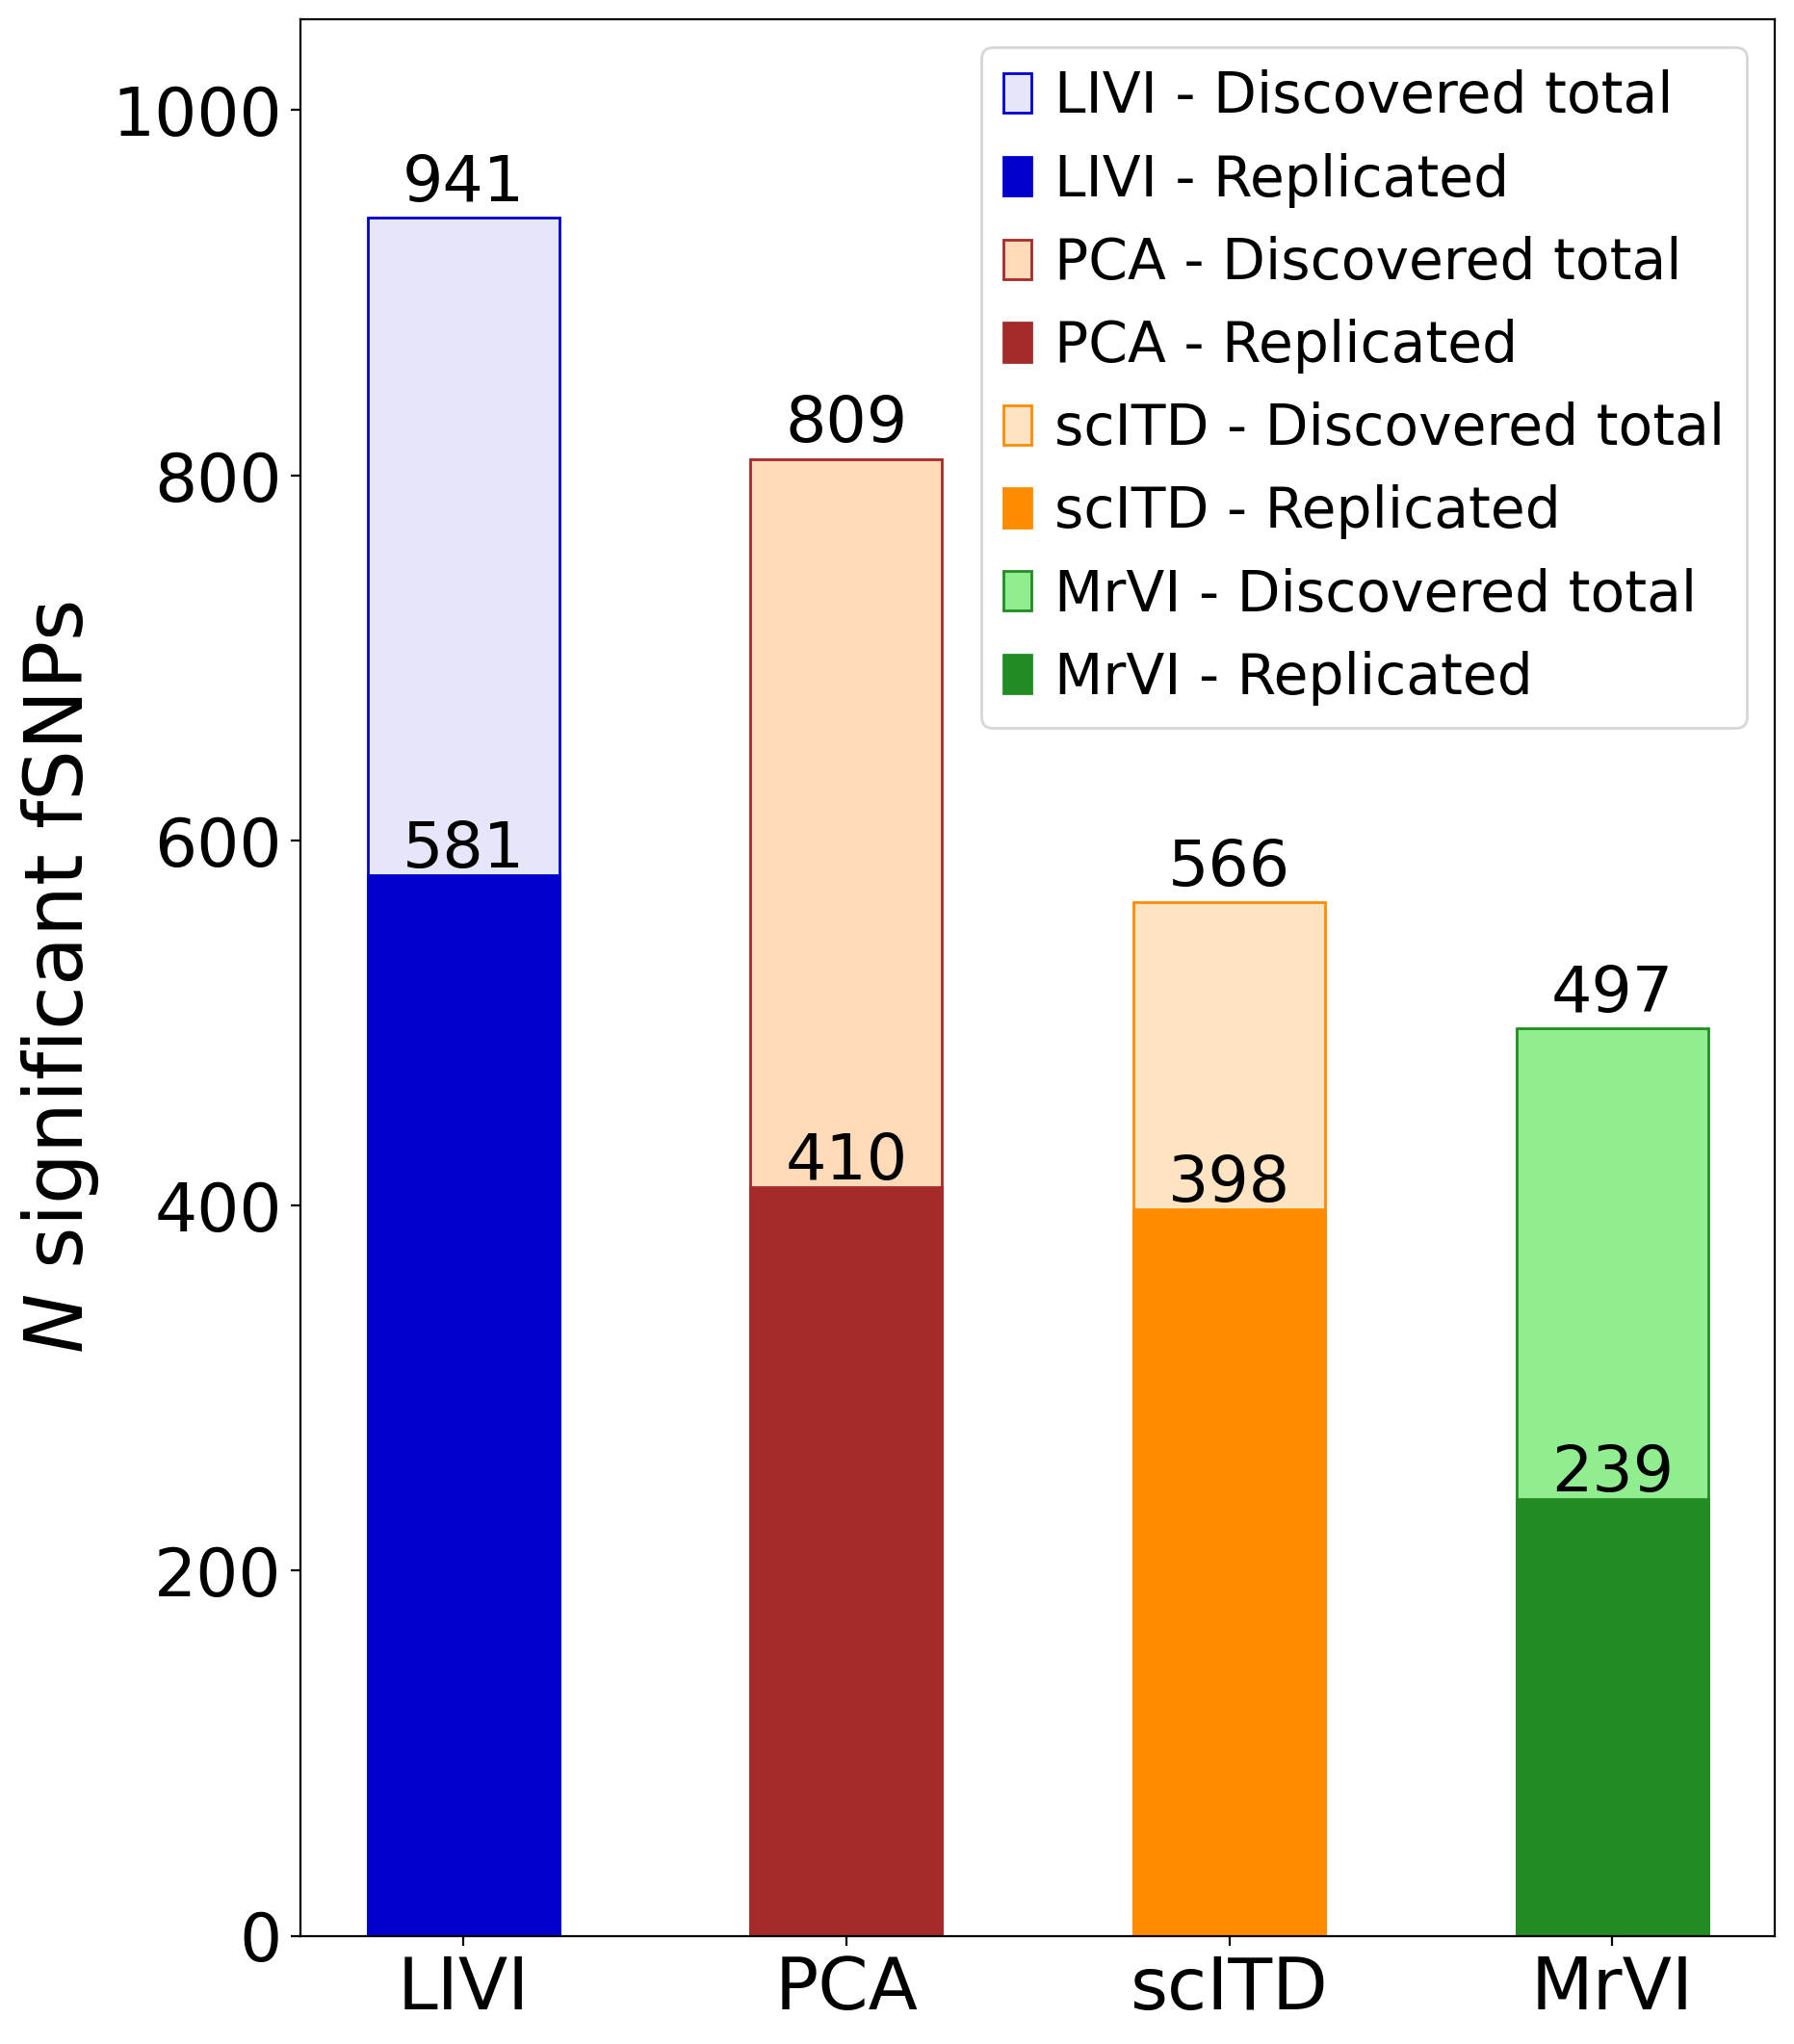

In [30]:
# Place bars from more to less discoveries
benchmarks_sorted = benchmarks.sort_values(by="discovered", ascending=False)
sorted_model_names = benchmarks_sorted["model"].unique()
sorted_position_dict = {name: i for i, name in enumerate(sorted_model_names)}

# Wrap text of model names
plot_model_names = [mn.replace(",", ",\n") for mn in sorted_model_names]
plot_model_names = [mn.replace("decoder", "\ndecoder") if "VAE" in mn else mn for mn in plot_model_names]

colors = {
    "PCA": ["peachpuff", "brown"],
    "MrVI": ["lightgreen", "forestgreen"],
    "LIVI": ["lavender", "mediumblue"],
    "scITD": ["bisque", "darkorange"]
}

legend_handles = []
legend_labels = []

fig, axs = plt.subplots(figsize=(9.2, 10.5), constrained_layout=True)

for i, row in benchmarks_sorted.iterrows():
    pos = sorted_position_dict[row["model"]]
    color_discovered = colors[row["model"]][0]
    color_replicated = colors[row["model"]][1]
    
    # Plot the discovered bar
    bar_discovered = axs.bar(pos, row["discovered"], color=color_discovered, width=0.5, edgecolor=color_replicated)  #"black")
    if f"{row['model']} - Discovered total" not in legend_labels:
        legend_handles.append(bar_discovered)
        legend_labels.append(f"{row['model']} - Discovered total")
    
    # Plot the replicated_trans bar on top of discovered
    bar_replicated = axs.bar(pos, row["discovered"] * (row["replicated_trans"] / row["discovered"]), color=color_replicated, 
                             width=0.5, edgecolor=color_replicated) # "black")
    if f"{row['model']} - Replicated in $trans$-eQTLGen" not in legend_labels:
        legend_handles.append(bar_replicated)
        legend_labels.append(f"{row['model']} - Replicated") # Replicated in $trans$-eQTLGen

    # Annotate bars with n discoveries
    axs.text(pos, row["discovered"]+2, str(row["discovered"]), ha="center", va="bottom", color="black", fontsize=24)
    axs.text(pos, row["discovered"] * (row["replicated_trans"] / row["discovered"])-3, str(row["replicated_trans"]), 
             ha="center", va="bottom", color="black", fontsize=24)

axs.legend(handles=[handle[0] for handle in legend_handles], labels=legend_labels, fontsize=21)

axs.set_ylim(bottom=0, top=1050)
axs.set_xticks(range(len(sorted_model_names)), plot_model_names, rotation=0, fontsize=27)
# axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), fontsize=18)
axs.set_yticks(np.arange(0,1100, 200), np.arange(0,1100,200), fontsize=25)
axs.set_ylabel("$N$ significant fSNPs", fontdict={"fontsize":30})
# axs.set_title("Number of SNPs with significant associations and replication in $trans$-eQTLGen", fontdict={"fontsize":20, "fontweight":"bold"})

plt.savefig(os.path.join(model_results_dir, "Figures", "Benchmarks_barplot_MrVI_each-model-best.png"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "Benchmarks_barplot_MrVI_each-model-best.eps"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "Benchmarks_barplot_MrVI_each-model-best.pdf"),
            bbox_inches="tight", dpi=500, transparent=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


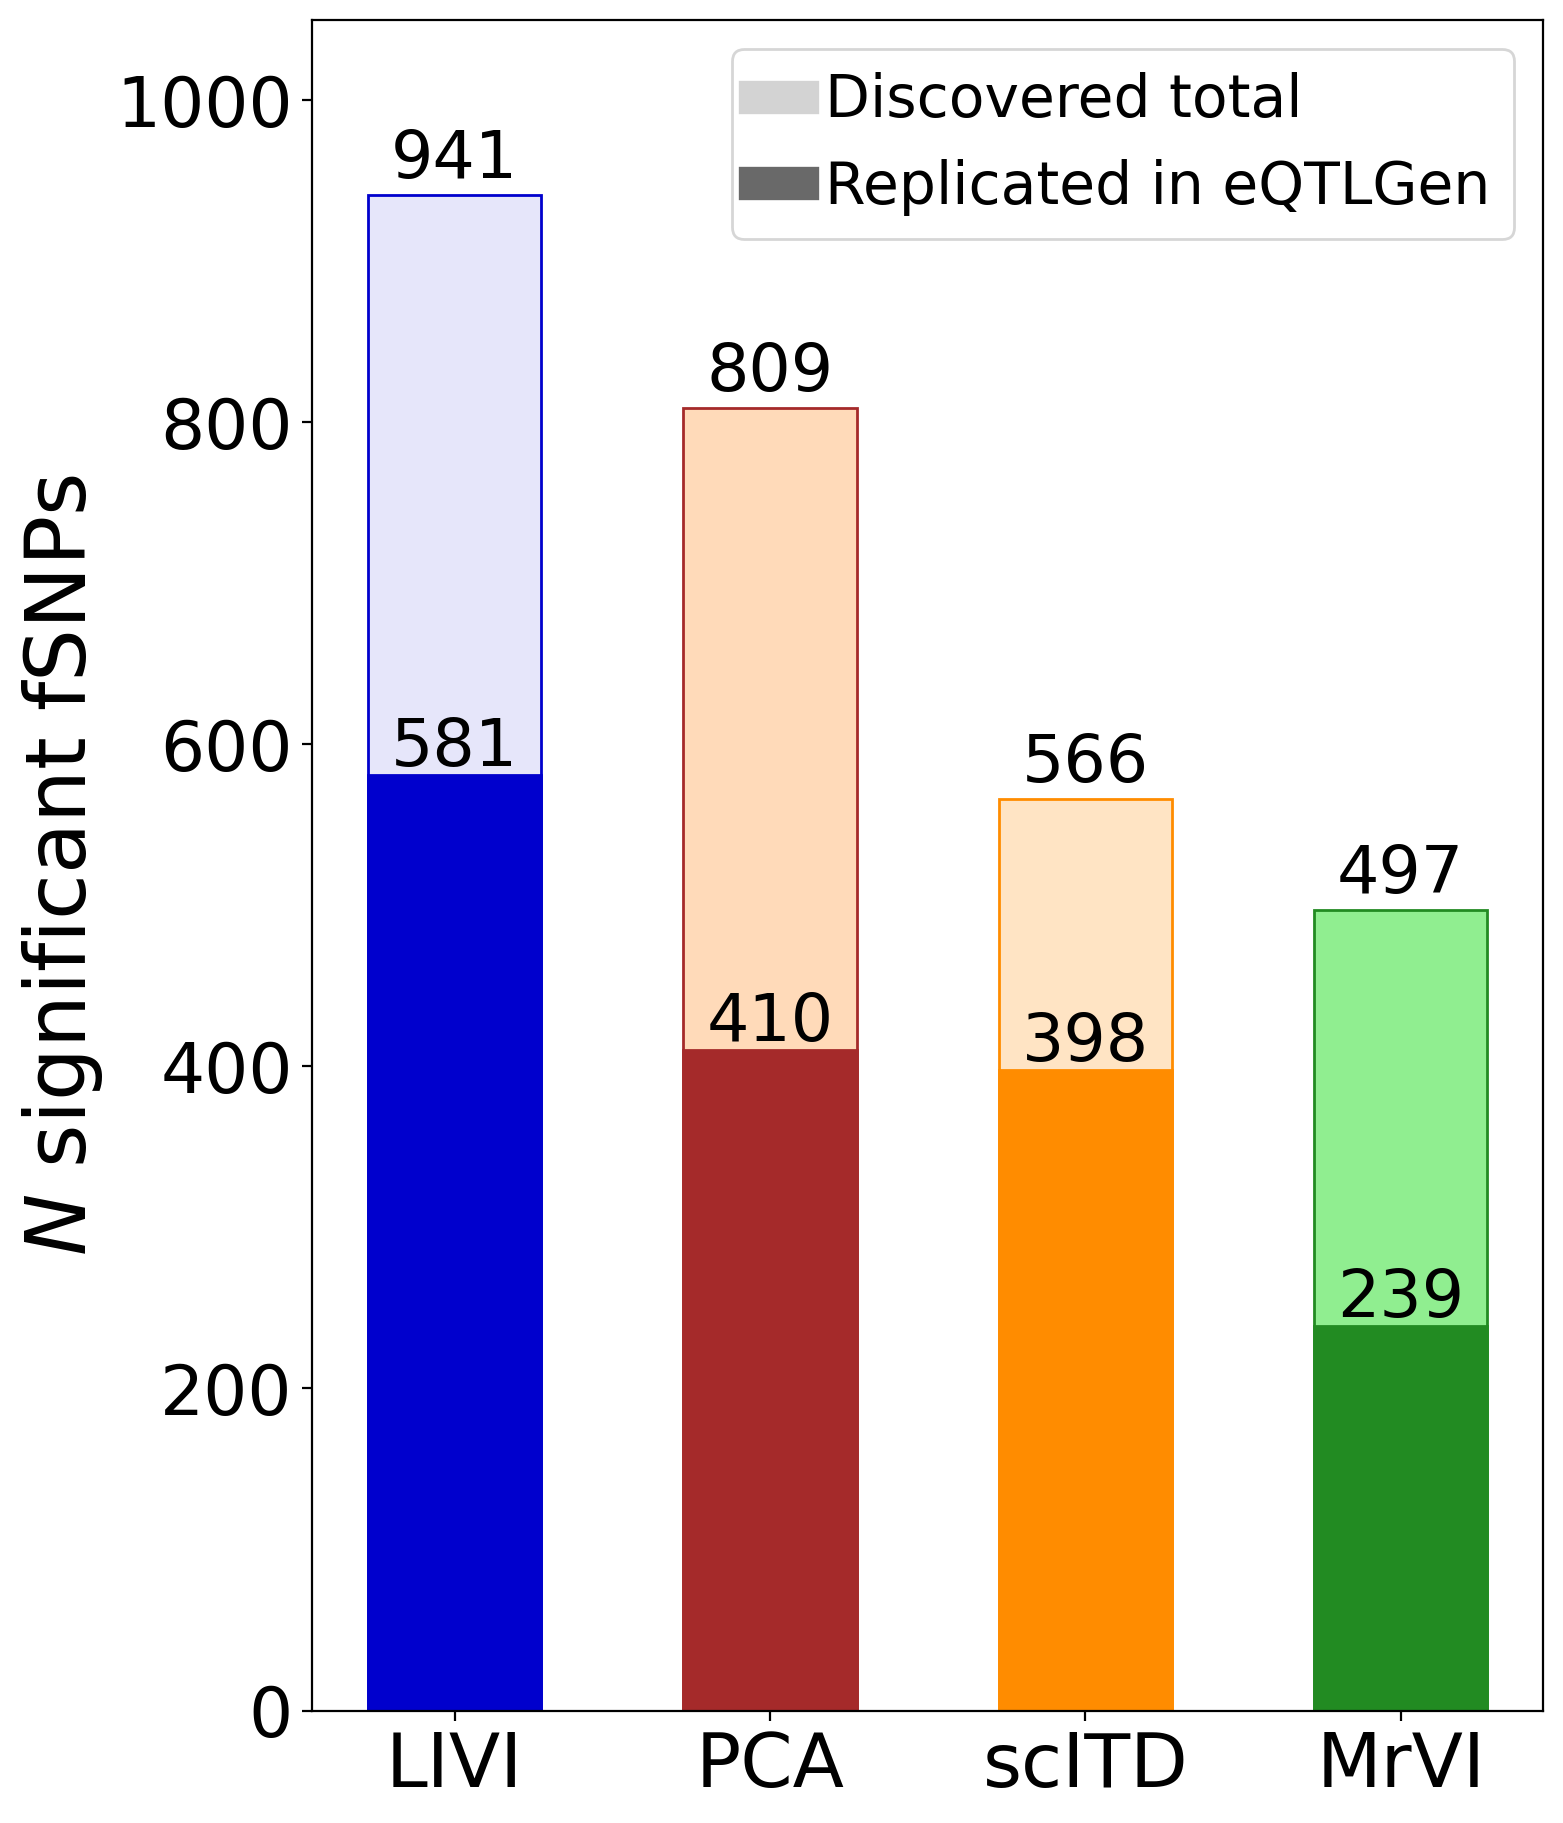

In [33]:
# Place bars from more to less discoveries
benchmarks_sorted = benchmarks.sort_values(by="discovered", ascending=False)

# Redefine the position dict based on the sorted dataframe
sorted_model_names = benchmarks_sorted["model"].unique()
sorted_position_dict = {name: i for i, name in enumerate(sorted_model_names)}
# Wrap text of model names
plot_model_names = [mn.replace(",", ",\n") for mn in sorted_model_names]
plot_model_names = [mn.replace("decoder", "\ndecoder") if "VAE" in mn else mn for mn in plot_model_names]

colors = {
    "PCA": ["peachpuff", "brown"],
    "MrVI": ["lightgreen", "forestgreen"],
    "LIVI": ["lavender", "mediumblue"],
    "scITD": ["bisque", "darkorange"]
}

legend_handles = []
legend_labels = []

fig, axs = plt.subplots(figsize=(7.7, 9), constrained_layout=True)

for i, row in benchmarks_sorted.iterrows():
    pos = sorted_position_dict[row["model"]]
    color_discovered = colors[row["model"]][0]
    color_replicated = colors[row["model"]][1]
    
    # Plot the discovered bar
    bar_discovered = axs.bar(pos, row["discovered"], color=color_discovered, width=0.55, edgecolor=color_replicated)  #"black")
    
    # Plot the replicated_trans bar on top of discovered
    bar_replicated = axs.bar(pos, row['discovered'] * (row["replicated_trans"] / row["discovered"]), color=color_replicated, 
                             width=0.55, edgecolor=color_replicated) # "black")

    # Annotate bars with n discoveries
    axs.text(pos, row["discovered"]+2, str(row["discovered"]), ha="center", va="bottom", color="black", fontsize=24)
    axs.text(pos, row["discovered"] * (row["replicated_trans"] / row["discovered"])-3, str(row["replicated_trans"]), 
             ha="center", va="bottom", color="black", fontsize=24)

legend_handles = [
    Line2D([0], [0], color="lightgrey", lw=12, label="Discovered total"),
    Line2D([0], [0], color="dimgrey", lw=12, label="Replicated in eQTLGen"),
]
axs.legend(handles=legend_handles, fontsize=21, handlelength=0.8)


axs.set_ylim(bottom=0, top=1050)
axs.set_xticks(range(len(sorted_model_names)), plot_model_names, rotation=0, fontsize=27)
# axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), fontsize=18)
axs.set_yticks(np.arange(0,1100, 200), np.arange(0,1100,200), fontsize=25)
axs.set_ylabel("$N$ significant fSNPs", fontdict={"fontsize":30})
# axs.set_title("Number of SNPs with significant associations and replication in $trans$-eQTLGen", fontdict={"fontsize":20, "fontweight":"bold"})

plt.savefig(os.path.join(model_results_dir, "Figures", "Benchmarks_barplot_MrVI_each-model-best_simple-legend.png"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "Benchmarks_barplot_MrVI_each-model-best_simple-legend.eps"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "Benchmarks_barplot_MrVI_each-model-best_simple-legend.pdf"),
            bbox_inches="tight", dpi=500, transparent=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


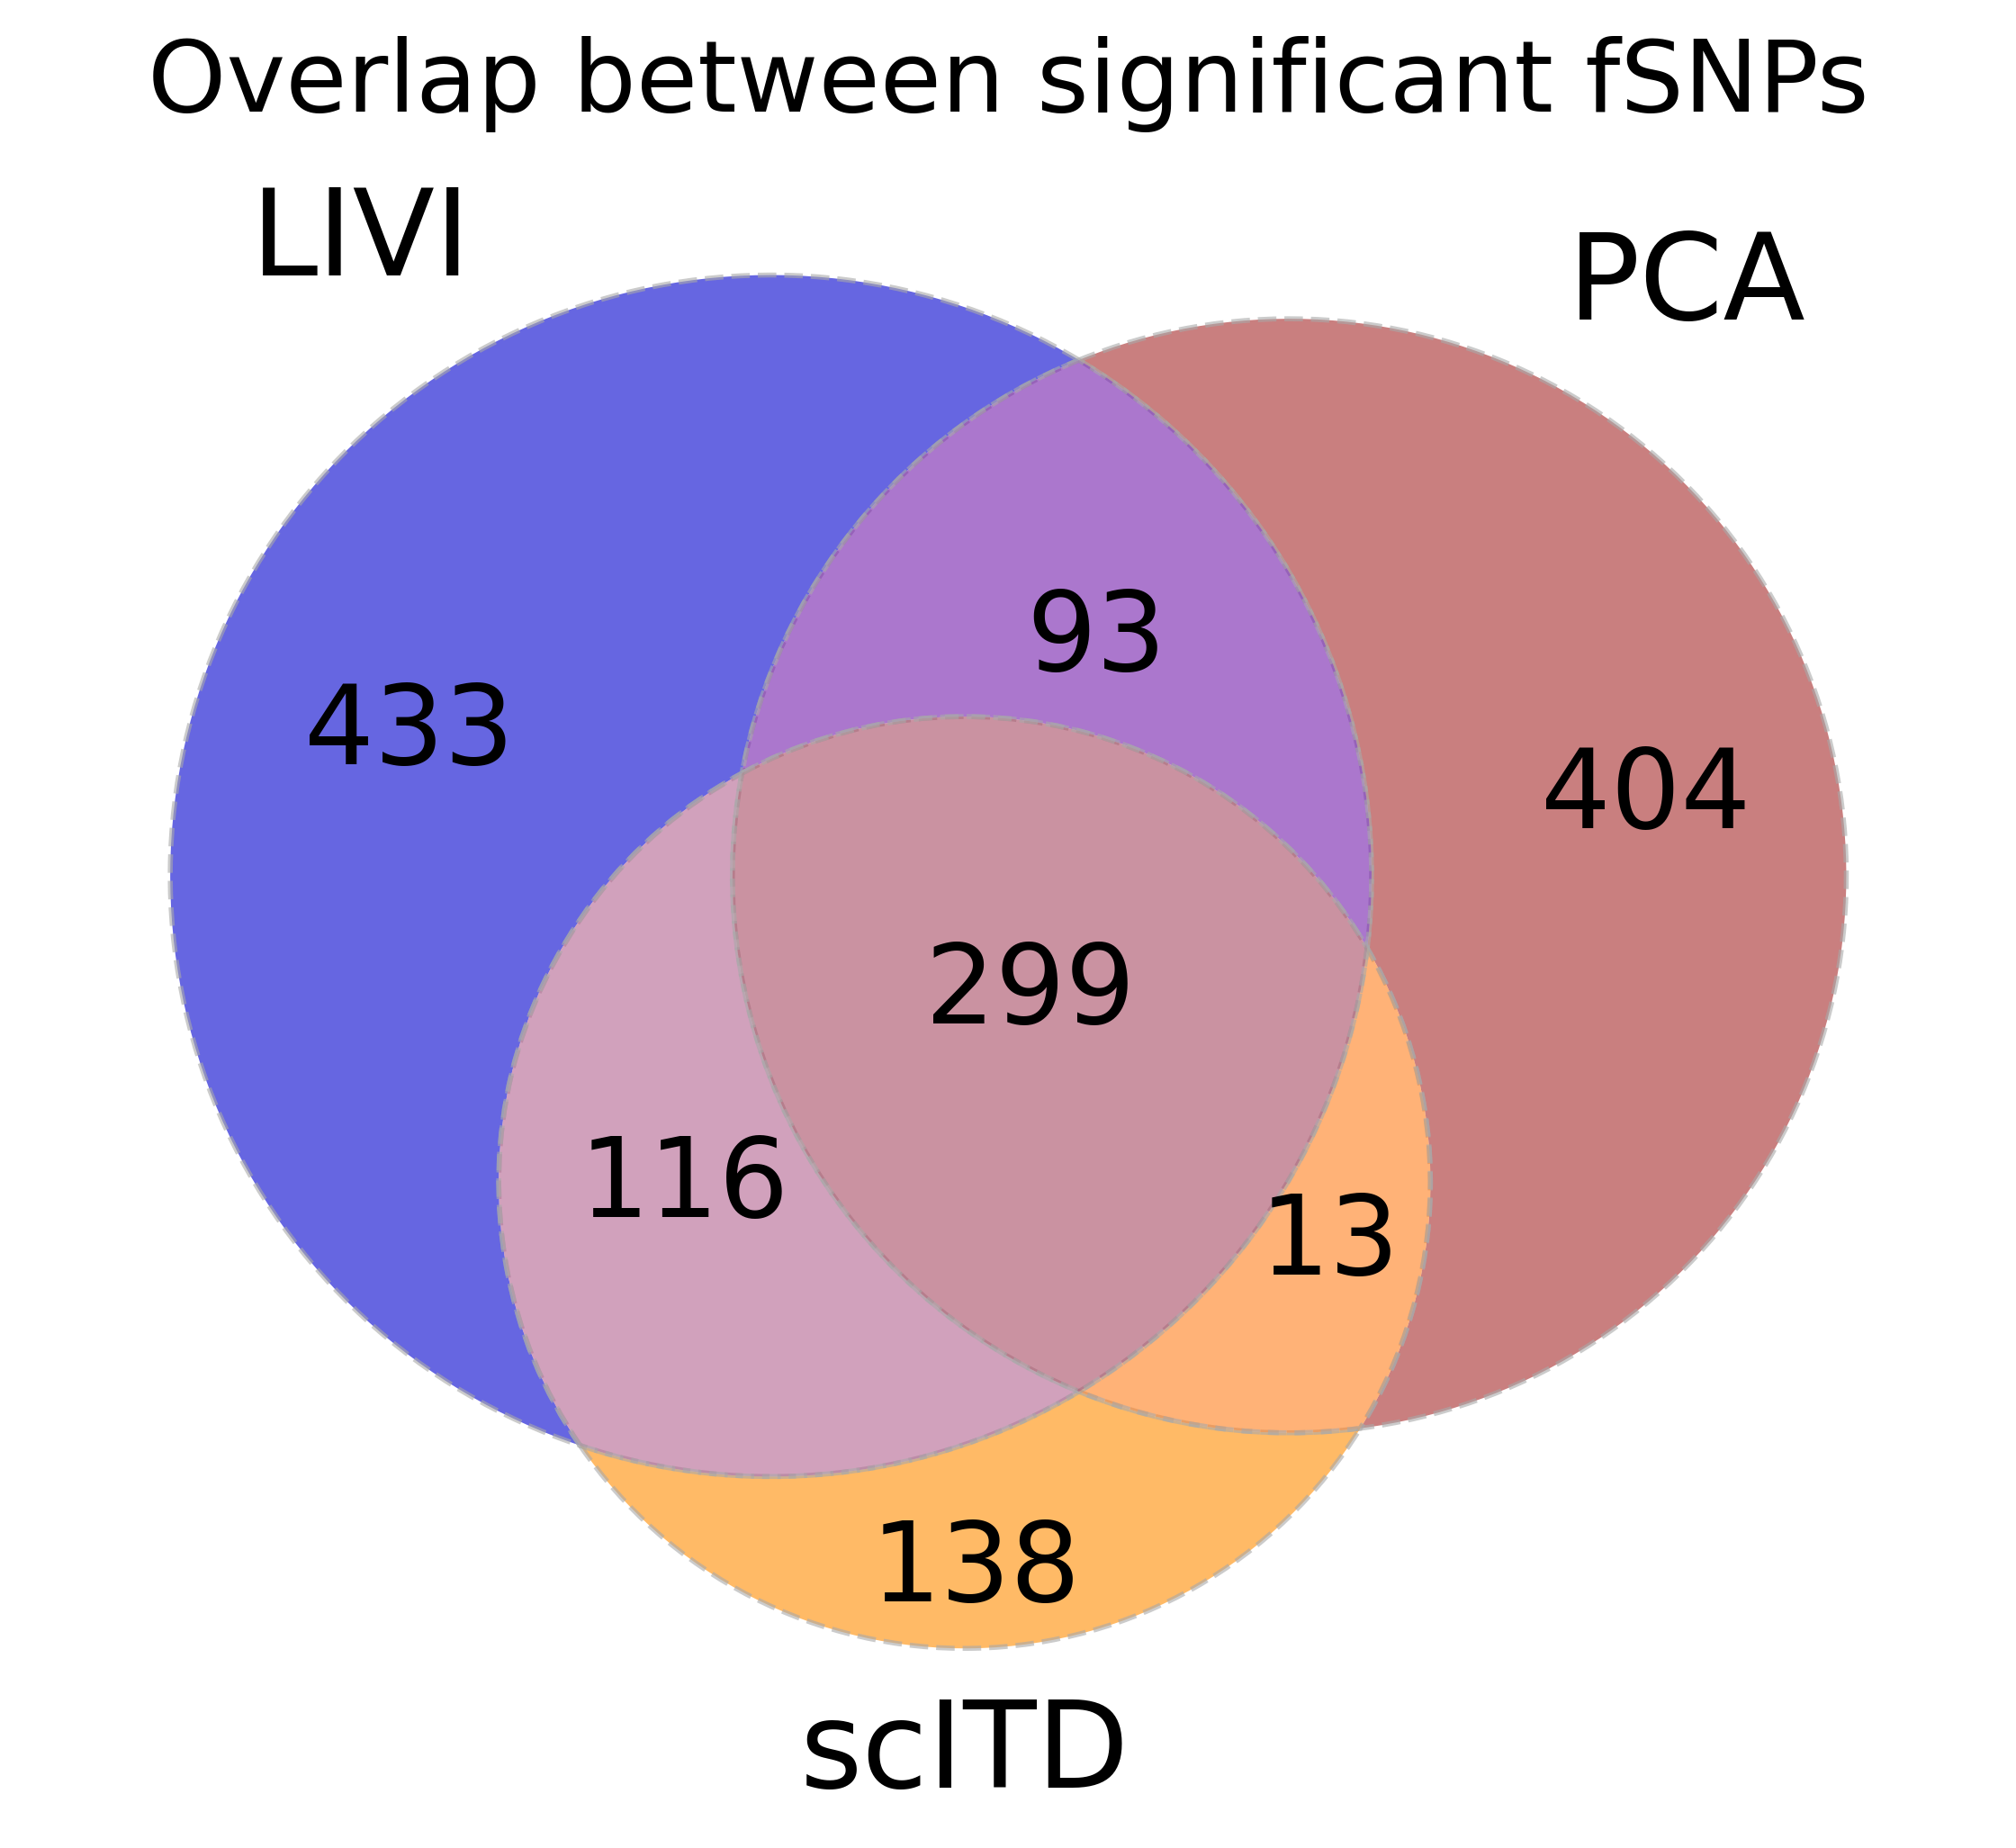

In [84]:
v = venn3(subsets=[set(GxC_effects.SNP_id), set(pca_celltype.SNP_id), set(scITD.SNP_id)],
          set_labels=("LIVI", "PCA", "scITD"), set_colors=("mediumblue", "brown", "darkorange"), alpha=0.6)
# Set font size for the labels
[l.set_fontsize(24) for l in v.set_labels]
for l in v.subset_labels:
    try:
        l.set_fontsize(22)
    except AttributeError:
        print(l)

for circle in v.patches:
    if circle is not None:  # Check if the patch exists to avoid errors
        circle.set_edgecolor("darkgrey")
        circle.set_linestyle("dashed")

plt.title("Overlap between significant fSNPs", fontsize=20)
plt.savefig(os.path.join(model_results_dir, "Figures", "SNP_overlap_LIVI_vs_PCA_vs_scITD_each-model-best.eps"), transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "SNP_overlap_LIVI_vs_PCA_vs_scITD_each-model-best.png"), transparent=False, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "SNP_overlap_LIVI_vs_PCA_vs_scITD_each-model-best.pdf"), transparent=True, bbox_inches="tight", dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


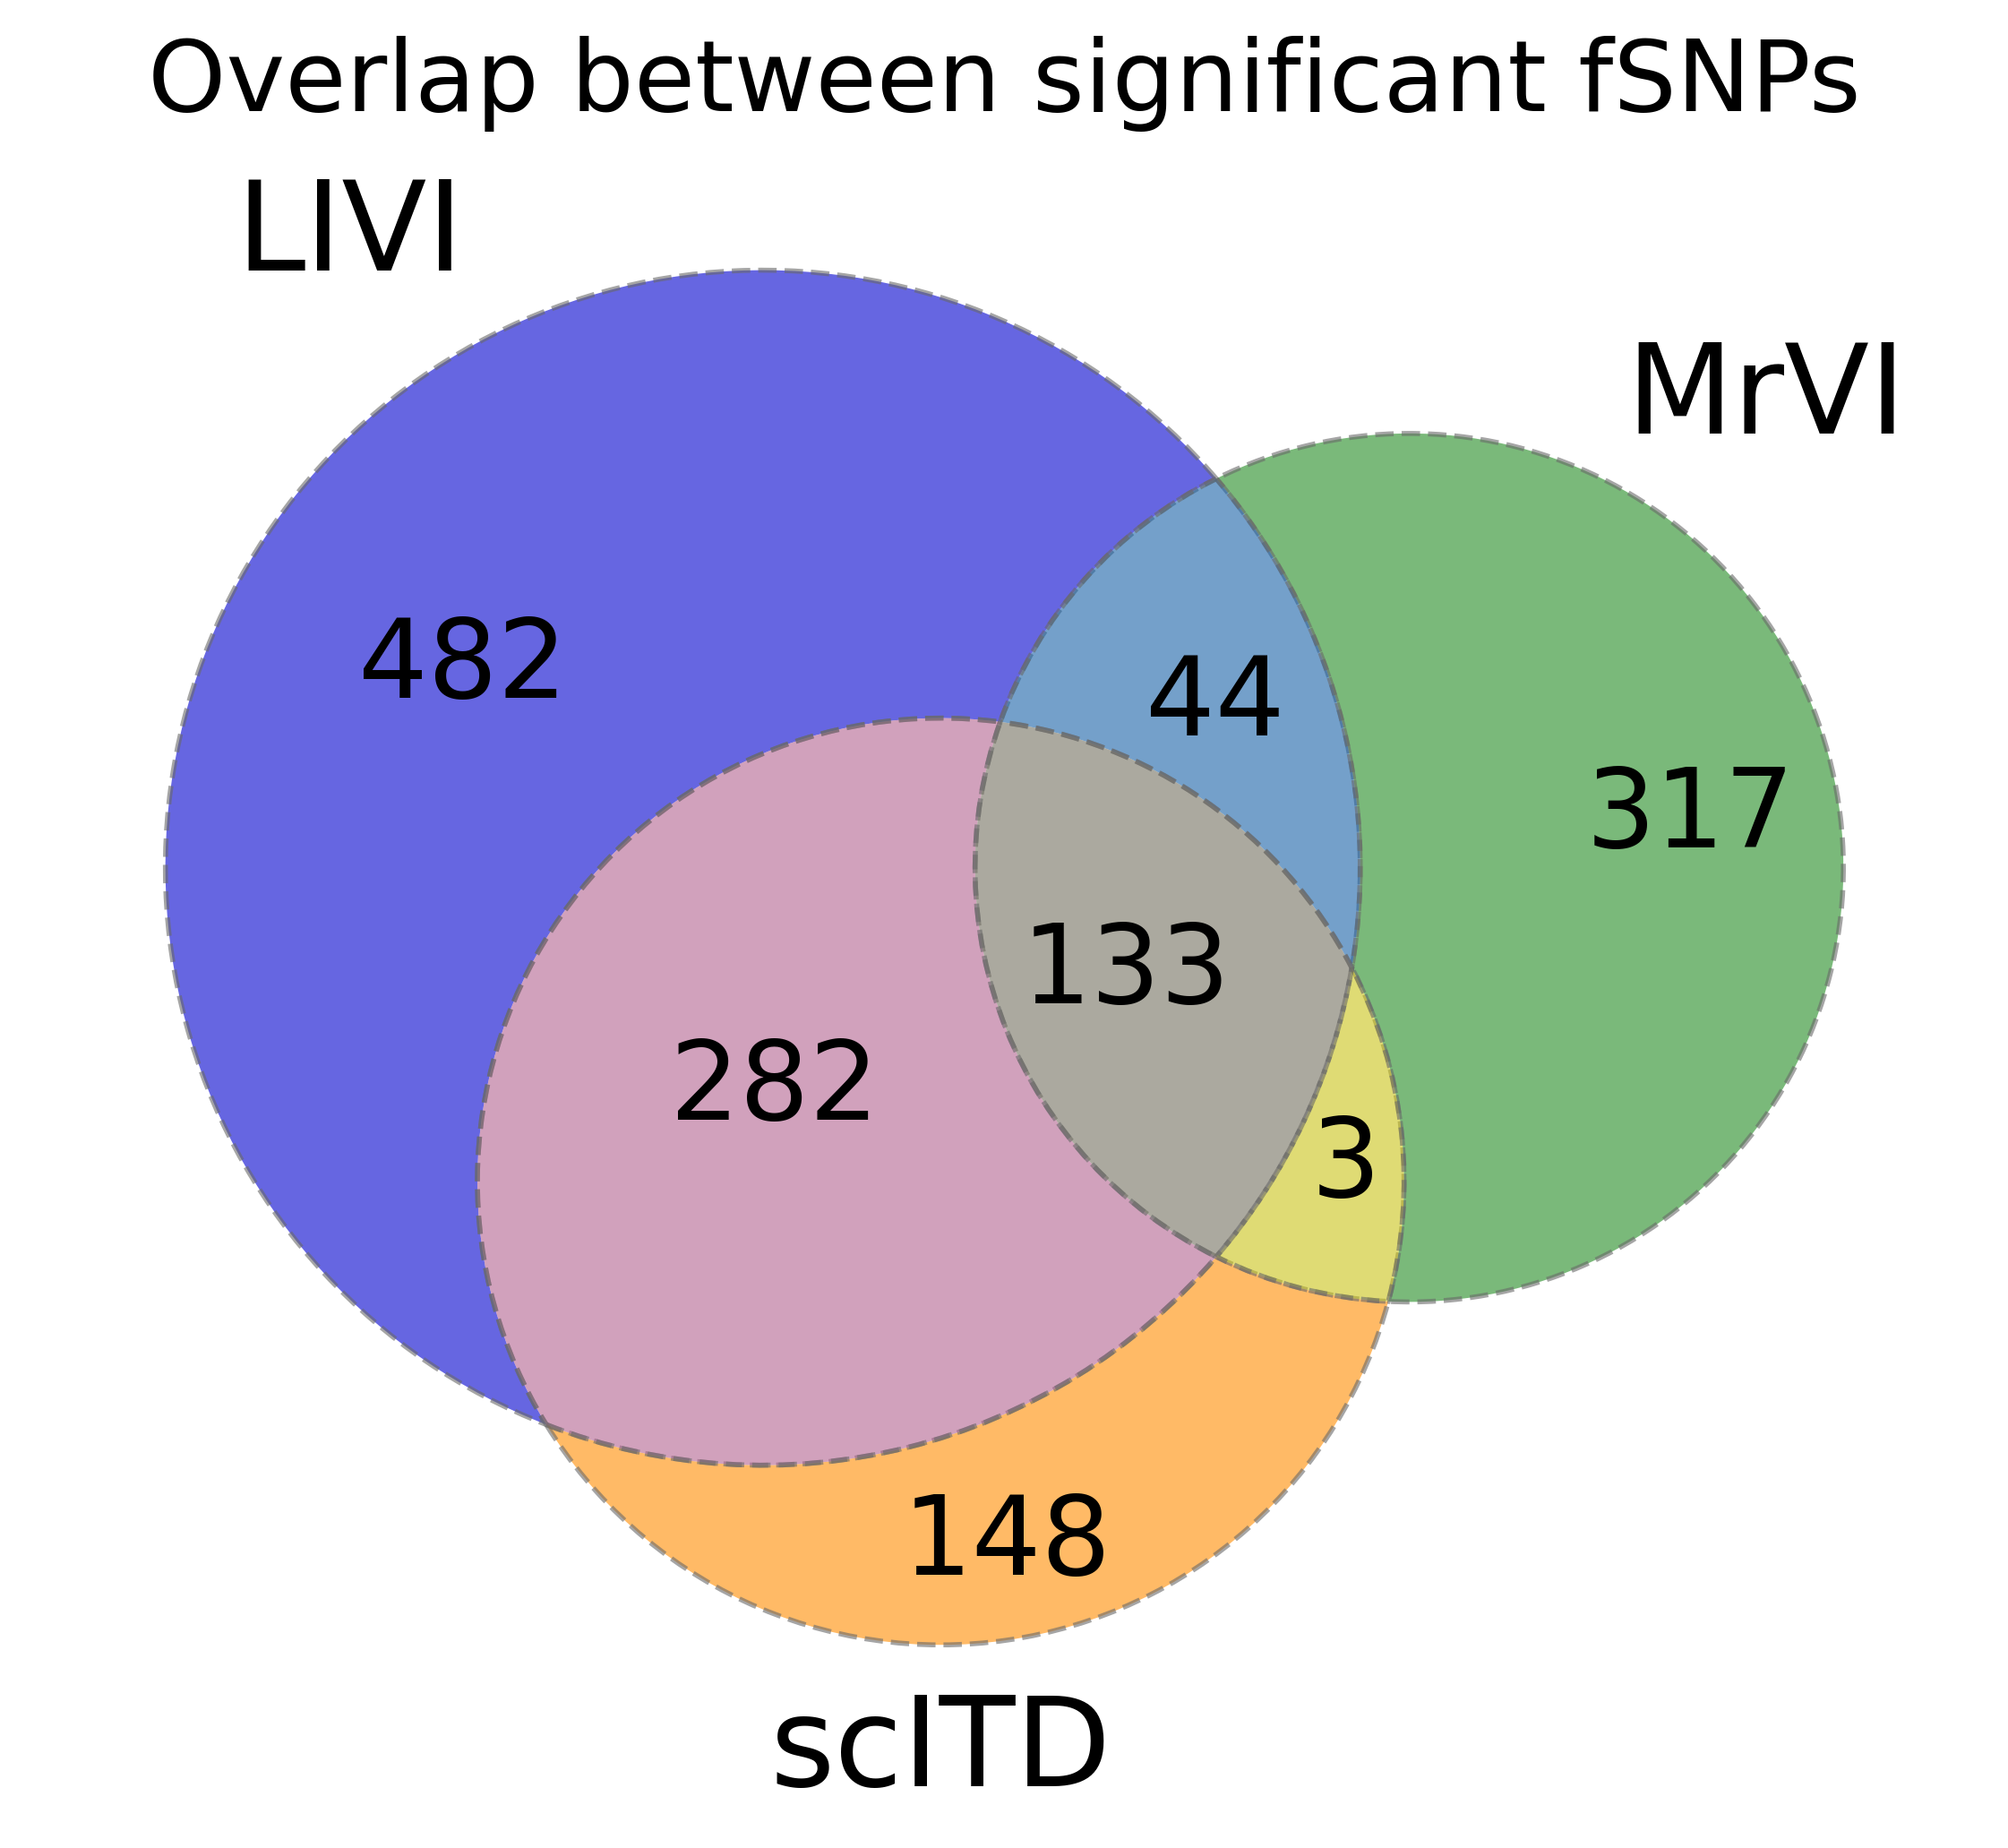

In [85]:
v = venn3(subsets=[set(GxC_effects.SNP_id), set(MrVI.SNP_id), set(scITD.SNP_id)],
          set_labels=("LIVI", "MrVI", "scITD"), set_colors=("mediumblue", "forestgreen", "darkorange"), alpha=0.6)
# Set font size for the labels
[l.set_fontsize(25) for l in v.set_labels]
for l in v.subset_labels:
    try:
        l.set_fontsize(22)
    except AttributeError:
        print(l)

for circle in v.patches:
    if circle is not None:  # Check if the patch exists to avoid errors
        circle.set_edgecolor("dimgrey")
        circle.set_linestyle("dashed")

plt.title("Overlap between significant fSNPs", fontsize=20)
plt.savefig(os.path.join(model_results_dir, "Figures", "SNP_overlap_LIVI_vs_MrVI_vs_scITD_each-model-best.eps"), transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "SNP_overlap_LIVI_vs_MrVI_vs_scITD_each-model-best.png"), transparent=False, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "SNP_overlap_LIVI_vs_MrVI_vs_scITD_each-model-best.pdf"), transparent=True, bbox_inches="tight", dpi=600)

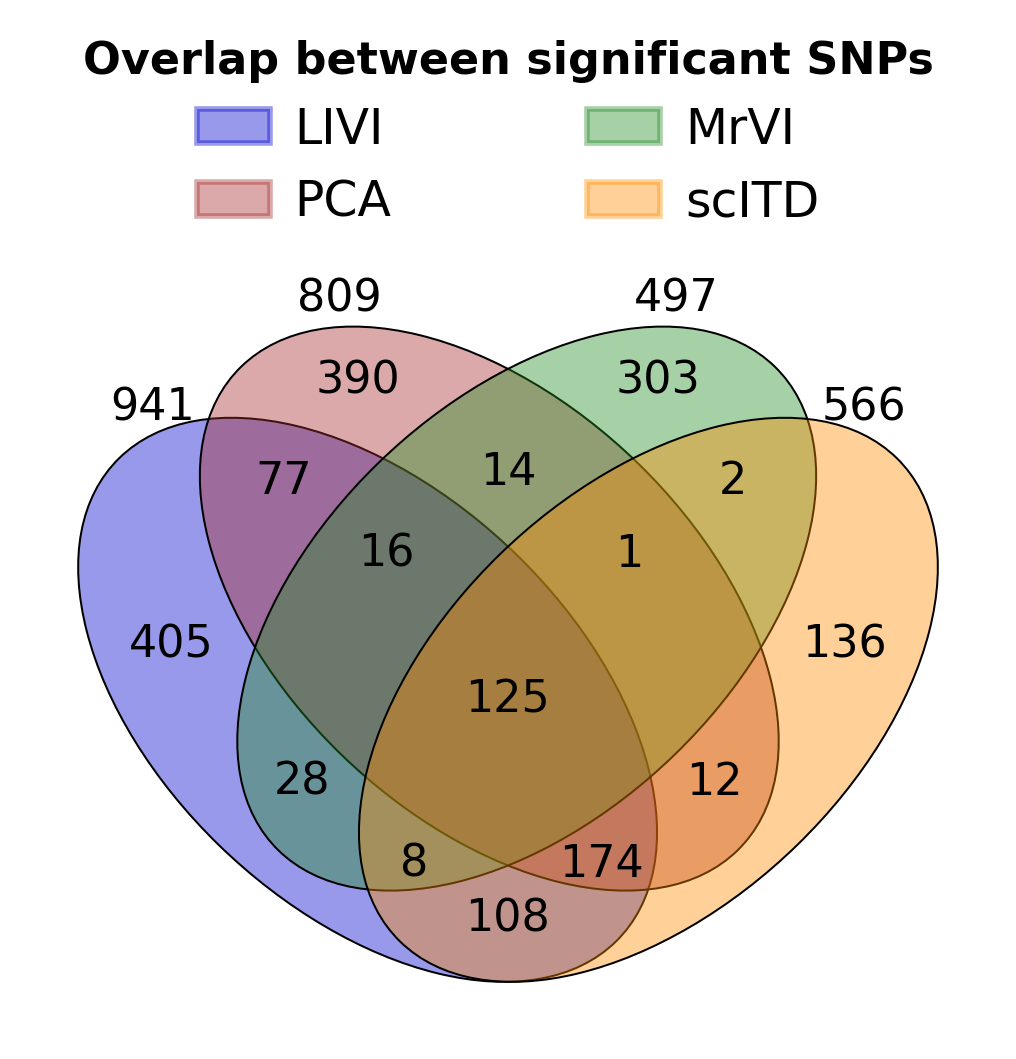

In [86]:
venny4py_custom_colors(sets={"LIVI": set(GxC_effects.SNP_id),
                             "PCA": set(pca_celltype.SNP_id),
                             "MrVI": set(MrVI.SNP_id),
                             "scITD":set(scITD.SNP_id)}, 
                       custom_colors=["mediumblue", "brown", "forestgreen", "darkorange"], 
                       plot_title="Overlap between significant SNPs",
                       out=os.path.join(model_results_dir, "Figures", "SNP-Overlap_LIVI_PCA_scITD_MrVI_each-model-best"),
                       alpha=0.4,
                       fontsize=8,
                       size=3)

### Replication vs. association p-value rank

In [16]:
GxC_effects_all = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_LMM_results_Ucontext.tsv"),
    sep="\t")

GxC_effects_all

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele
0,U_Factor1,1:1247494,-0.069020,0.035374,0.050816,C
1,U_Factor1,1:1894284,-0.024518,0.031360,0.434237,T
2,U_Factor1,1:2069172,0.012003,0.030091,0.689958,C
3,U_Factor1,1:2146165,0.021488,0.053250,0.686544,C
4,U_Factor1,1:2233961,0.032077,0.036350,0.377428,G
...,...,...,...,...,...,...
6521895,U_Factor700,22:50971752,-0.045634,0.067433,0.498529,C
6521896,U_Factor700,22:50991033,-0.008982,0.056588,0.873881,T
6521897,U_Factor700,22:51063477,-0.145870,0.102566,0.154756,T
6521898,U_Factor700,22:51101938,0.112992,0.066963,0.091294,A


In [17]:
GxC_effects = GxC_effects.assign(fQTL = GxC_effects["SNP_id"]+"__"+GxC_effects["Factor"])
GxC_effects_all = GxC_effects_all.assign(fQTL = GxC_effects_all["SNP_id"]+"__"+GxC_effects_all["Factor"])

In [18]:
smallest_pval_idx = GxC_effects_all.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.p_value.nsmallest(1), include_groups=False).index
assert len(smallest_pval_idx) == GxC_effects_all.SNP_id.nunique()

In [19]:
len(smallest_pval_idx)

9299

In [20]:
SNPs_sorted = GxC_effects_all.loc[smallest_pval_idx].sort_values("p_value", ascending=True).filter(["SNP_id", "p_value", "Storey_qvals", "fQTL"])
SNPs_sorted.head()

,SNP_id,p_value,fQTL
6479072,6:34302869,6.072334e-261,6:34302869__U_Factor696
2305593,7:22856606,8.839926e-229,7:22856606__U_Factor248
2724204,6:32429643,7.226991e-214,6:32429643__U_Factor293
2724206,6:32433167,7.226991e-214,6:32433167__U_Factor293
4047795,6:167392174,7.077171e-212,6:167392174__U_Factor435


In [64]:
SNPs_sorted["in_trans_eQTLGen"] =  SNPs_sorted.SNP_id.isin(trans_eQTLGen_sign.snp_id)
SNPs_sorted.head()

,SNP_id,p_value,fQTL,in_trans_eQTLGen
6479072,6:34302869,6.072334e-261,6:34302869__U_Factor696,False
2305593,7:22856606,8.839926e-229,7:22856606__U_Factor248,False
2724204,6:32429643,7.226991e-214,6:32429643__U_Factor293,True
2724206,6:32433167,7.226991e-214,6:32433167__U_Factor293,True
4047795,6:167392174,7.077171e-212,6:167392174__U_Factor435,True


In [65]:
SNPs_sorted["pvalue_rank"] = np.arange(1,SNPs_sorted.shape[0]+1)
SNPs_sorted.head()

,SNP_id,p_value,fQTL,in_trans_eQTLGen,pvalue_rank
6479072,6:34302869,6.072334e-261,6:34302869__U_Factor696,False,1
2305593,7:22856606,8.839926e-229,7:22856606__U_Factor248,False,2
2724204,6:32429643,7.226991e-214,6:32429643__U_Factor293,True,3
2724206,6:32433167,7.226991e-214,6:32433167__U_Factor293,True,4
4047795,6:167392174,7.077171e-212,6:167392174__U_Factor435,True,5


In [66]:
SNPs_sorted["Replication_trans"] = SNPs_sorted["in_trans_eQTLGen"].cumsum()
SNPs_sorted.head()

,SNP_id,p_value,fQTL,in_trans_eQTLGen,pvalue_rank,Replication_rate_trans
6479072,6:34302869,6.072334e-261,6:34302869__U_Factor696,False,1,0.000000
2305593,7:22856606,8.839926e-229,7:22856606__U_Factor248,False,2,0.000000
2724204,6:32429643,7.226991e-214,6:32429643__U_Factor293,True,3,0.333333
2724206,6:32433167,7.226991e-214,6:32433167__U_Factor293,True,4,0.500000
4047795,6:167392174,7.077171e-212,6:167392174__U_Factor435,True,5,0.600000


In [67]:
scITD_all = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/scITD/scITD_14kgenes_700_factors_900_donors_LMM_results_Ucontext.tsv", sep="\t", index_col=False)
scITD_all

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele
0,V1,1:1247494,0.000076,0.000295,0.796085,C
1,V1,1:1894284,0.000267,0.000262,0.309091,T
2,V1,1:2069172,-0.000031,0.000252,0.901647,C
3,V1,1:2146165,-0.000579,0.000446,0.193722,C
4,V1,1:2233961,0.000465,0.000305,0.126535,G
...,...,...,...,...,...,...
6521895,V700,22:50971752,0.002880,0.001868,0.122895,C
6521896,V700,22:50991033,0.002024,0.001559,0.194184,T
6521897,V700,22:51063477,0.001360,0.002838,0.631648,T
6521898,V700,22:51101938,0.000371,0.001850,0.840958,A


In [68]:
smallest_pval_idx_scITD = scITD_all.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.p_value.nsmallest(1), include_groups=False).index
assert len(smallest_pval_idx_scITD) == scITD_all.SNP_id.nunique()

In [69]:
len(smallest_pval_idx_scITD)

9299

In [70]:
SNPs_sorted_scITD = scITD_all.loc[smallest_pval_idx_scITD].sort_values("p_value", ascending=True).filter(["SNP_id", "p_value", "Storey_qvals"])
SNPs_sorted_scITD["in_trans_eQTLGen"] = SNPs_sorted_scITD.SNP_id.isin(trans_eQTLGen_sign.snp_id)
SNPs_sorted_scITD["pvalue_rank"] = np.arange(1, SNPs_sorted_scITD.shape[0]+1)
SNPs_sorted_scITD["Replication_trans"] = SNPs_sorted_scITD["in_trans_eQTLGen"].cumsum()
SNPs_sorted_scITD

,SNP_id,p_value,in_trans_eQTLGen,pvalue_rank,Replication_rate_trans
589929,5:96252589,2.225074e-308,True,1,1.000000
589930,5:96252803,2.225074e-308,True,2,1.000000
589928,5:96244549,2.225074e-308,True,3,1.000000
589931,5:96350088,2.225074e-308,True,4,1.000000
406467,11:306920,2.688744e-179,True,5,1.000000
...,...,...,...,...,...
5634501,14:61908111,9.811372e-03,False,9295,0.260463
837523,17:78102517,9.883433e-03,True,9296,0.260542
1838253,5:50529175,9.981597e-03,False,9297,0.260514
4216841,10:64257828,1.006839e-02,False,9298,0.260486


In [71]:
# PCA_celltype_all = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/PCA/All_celltypes_LMM_results_700-PCs-benchmark.tsv", sep="\t", index_col=False)
PCA_celltype_all = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/PCA/All_celltypes_LMM_results_100-PCs-benchmark.tsv", sep="\t", index_col=False)
smallest_pval_idx_pca = PCA_celltype_all.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.p_value.nsmallest(1), include_groups=False).index
SNPs_sorted_pca = PCA_celltype_all.loc[smallest_pval_idx_pca].sort_values("p_value", ascending=True).filter(["SNP_id", "p_value", "Storey_qvals"])
SNPs_sorted_pca["in_trans_eQTLGen"] = SNPs_sorted_pca.SNP_id.isin(trans_eQTLGen_sign.snp_id)
SNPs_sorted_pca["pvalue_rank"] = np.arange(1, SNPs_sorted_pca.shape[0]+1)
SNPs_sorted_pca["Replication_trans"] = SNPs_sorted_pca["in_trans_eQTLGen"].cumsum()

In [72]:
MrVI_all = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/MrVI/model_uz-attention_z500_u15/model_uz-attention_z500_u15_LMM_results_Ucontext.tsv", sep="\t", index_col=False)
smallest_pval_idx_MrVI = MrVI_all.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.p_value.nsmallest(1), include_groups=False).index
SNPs_sorted_MrVI = MrVI_all.loc[smallest_pval_idx_MrVI].sort_values("p_value", ascending=True).filter(["SNP_id", "p_value", "Storey_qvals"])
SNPs_sorted_MrVI["in_trans_eQTLGen"] = SNPs_sorted_MrVI.SNP_id.isin(trans_eQTLGen_sign.snp_id)
SNPs_sorted_MrVI["pvalue_rank"] = np.arange(1, SNPs_sorted_MrVI.shape[0]+1)
SNPs_sorted_MrVI["Replication_trans"] = SNPs_sorted_MrVI["in_trans_eQTLGen"].cumsum()

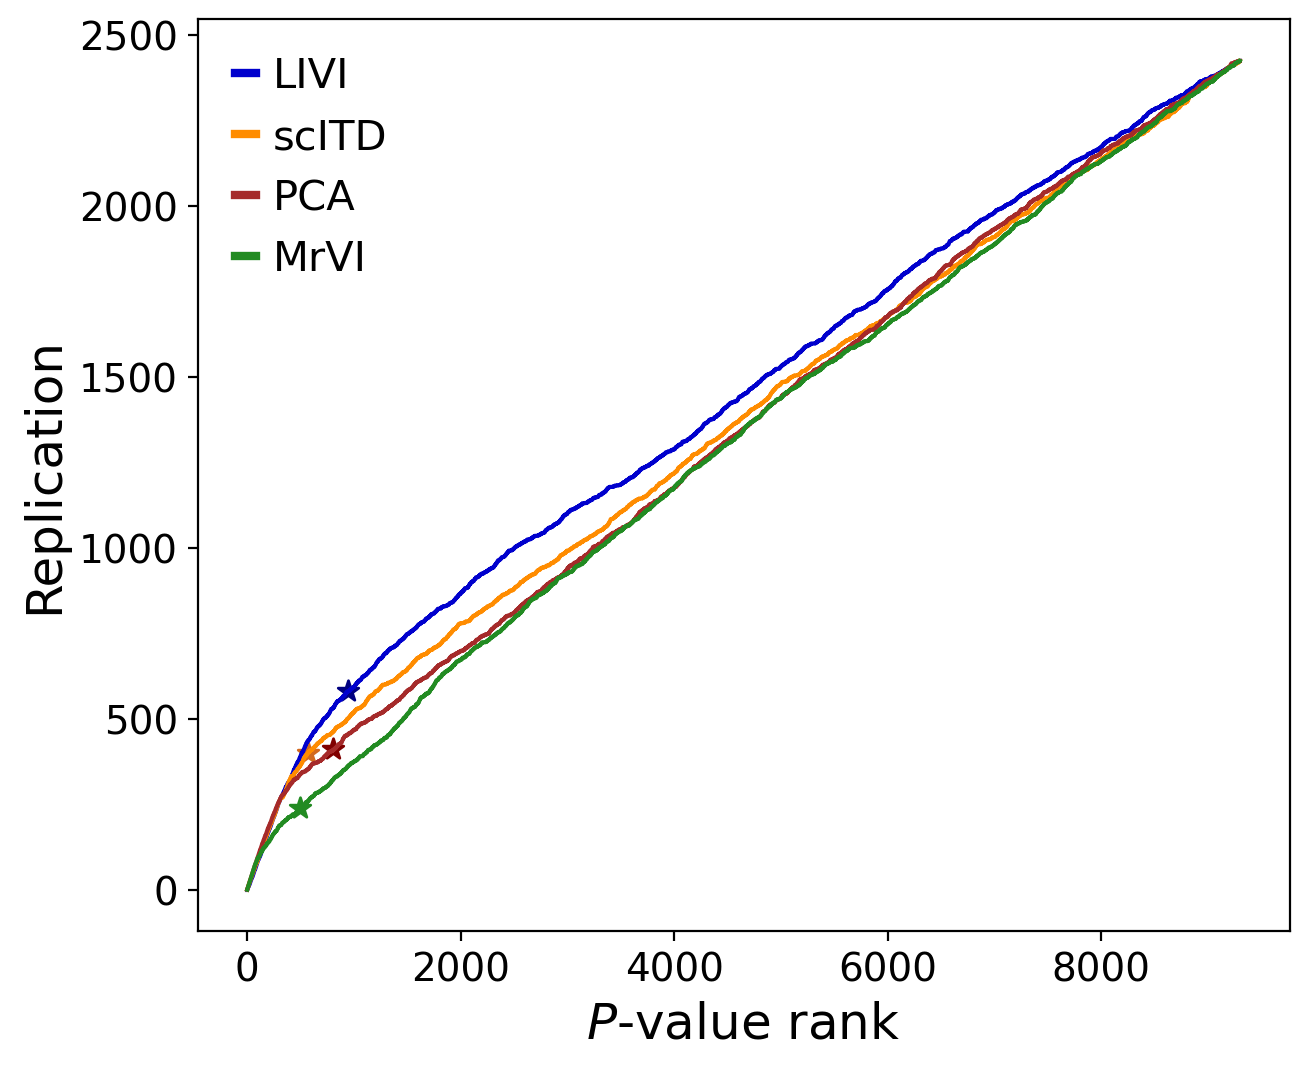

In [116]:
plt.figure(figsize=(7, 6), dpi=100)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted, color="mediumblue", label="LIVI", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_scITD, color="darkorange", label="scITD", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_pca, color="brown", label="PCA", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_MrVI, color="forestgreen", label="MrVI", rasterized=True)

plt.scatter(x=GxC_effects.SNP_id.nunique(),
            y=SNPs_sorted.sort_values("p_value").iloc[GxC_effects.SNP_id.nunique()]["Replication_trans"],
            c="navy", marker="*", s=60)
plt.scatter(x=scITD.SNP_id.nunique(),
            y=SNPs_sorted_scITD.sort_values("p_value").iloc[scITD.SNP_id.nunique()]["Replication_trans"], 
            c="chocolate", marker="*", s=60)
plt.scatter(x=pca_celltype.SNP_id.nunique(), 
            y=SNPs_sorted_pca.sort_values("p_value").iloc[pca_celltype.SNP_id.nunique()]["Replication_trans"],
            c="maroon", marker="*", s=60)
plt.scatter(x=MrVI.SNP_id.nunique(), 
            y=SNPs_sorted_MrVI.sort_values("p_value").iloc[MrVI.SNP_id.nunique()]["Replication_trans"],
            c="forestgreen", marker="*", s=60)

plt.xlabel("$P$-value rank", fontsize=18)
plt.ylabel("Replication", fontsize=18)

legend_handles = [
    Line2D([0], [0], color="mediumblue", lw=3, label="LIVI"), 
    Line2D([0], [0], color="darkorange", lw=3, label="scITD"),
    Line2D([0], [0], color="brown", lw=3, label="PCA"),
    Line2D([0], [0], color="forestgreen", lw=3, label="MrVI"),
    # Line2D([0], [0], color="forestgreen", lw=3, label="VAE, linear"),
    # Line2D([0], [0], color="darkgreen", lw=3, label="VAE, non-linear")
]
plt.legend(handles=legend_handles, fontsize=15, frameon=False, loc="upper left")

# plt.title("700 factors")
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_each-model-best.png"), 
            transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_each-model-best.eps"), 
            transparent=False, bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_each-model-best.pdf"), 
            transparent=True, bbox_inches="tight", dpi=600)

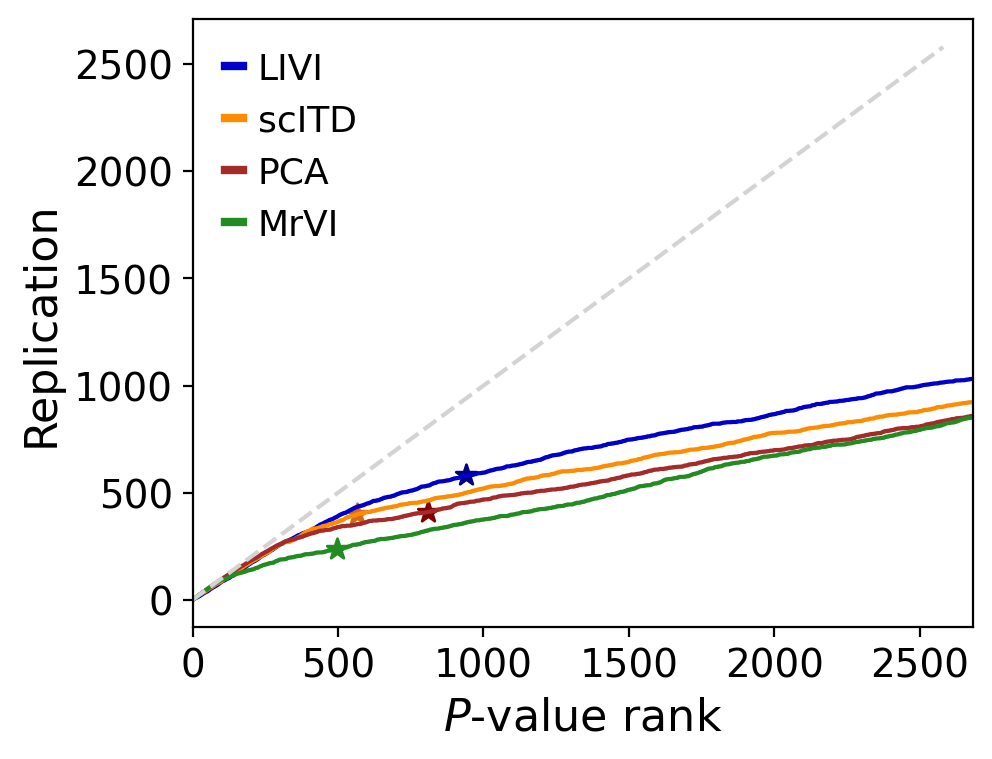

In [117]:
plt.figure(figsize=(5, 4), dpi=100)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted, color="mediumblue", label="LIVI", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_scITD, color="darkorange", label="scITD", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_pca, color="brown", label="PCA", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_MrVI, color="forestgreen", label="MrVI", rasterized=True)

plt.xlim(0, trans_eQTLGen_sign.snp_id.nunique()+100)
plt.scatter(x=GxC_effects.SNP_id.nunique(),
            y=SNPs_sorted.sort_values("p_value").iloc[GxC_effects.SNP_id.nunique()]["Replication_trans"],
            c="navy", marker="*", s=60)
plt.scatter(x=scITD.SNP_id.nunique(),
            y=SNPs_sorted_scITD.sort_values("p_value").iloc[scITD.SNP_id.nunique()]["Replication_trans"], 
            c="chocolate", marker="*", s=60)
plt.scatter(x=pca_celltype.SNP_id.nunique(), 
            y=SNPs_sorted_pca.sort_values("p_value").iloc[pca_celltype.SNP_id.nunique()]["Replication_trans"],
            c="maroon", marker="*", s=60)
plt.scatter(x=MrVI.SNP_id.nunique(), 
            y=SNPs_sorted_MrVI.sort_values("p_value").iloc[MrVI.SNP_id.nunique()]["Replication_trans"],
            c="forestgreen", marker="*", s=60)

plt.xlabel("$P$-value rank", fontsize=16)
plt.ylabel("Replication", fontsize=16)

plt.plot(np.arange(0, trans_eQTLGen_sign.snp_id.nunique()), np.arange(0, trans_eQTLGen_sign.snp_id.nunique()), linestyle="--", color="lightgrey")

legend_handles = [
    Line2D([0], [0], color="mediumblue", lw=3, label="LIVI"), 
    Line2D([0], [0], color="darkorange", lw=3, label="scITD"),
    Line2D([0], [0], color="brown", lw=3, label="PCA"),
    Line2D([0], [0], color="forestgreen", lw=3, label="MrVI"),
]
plt.legend(handles=legend_handles, fontsize=13, frameon=False, loc="upper left")

plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_ZOOM-IN_each-model-best.png"), 
            transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_ZOOM-IN_each-model-best.eps"), 
            transparent=False, bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_ZOOM-IN_each-model-best.pdf"), 
            transparent=True, bbox_inches="tight", dpi=600)

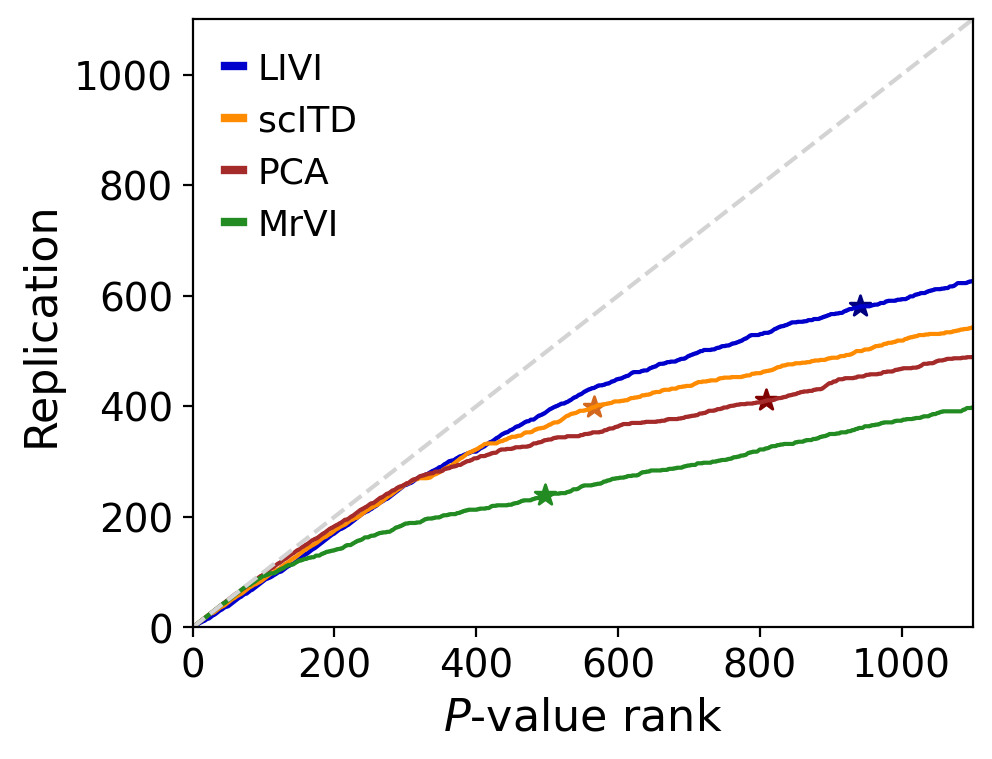

In [55]:
plt.figure(figsize=(5, 4), dpi=100)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted, color="mediumblue", label="LIVI", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_scITD, color="darkorange", label="scITD", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_pca, color="brown", label="PCA", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_MrVI, color="forestgreen", label="MrVI", rasterized=True)

plt.plot(np.arange(0, trans_eQTLGen_sign.snp_id.nunique()), np.arange(0, trans_eQTLGen_sign.snp_id.nunique()), 
         linestyle="--", color="lightgrey")

plt.xlim(0, 1100)
plt.ylim(0, 1100)
plt.scatter(x=GxC_effects.SNP_id.nunique(),
            y=SNPs_sorted.sort_values("p_value").iloc[GxC_effects.SNP_id.nunique()]["Replication_trans"],
            c="navy", marker="*", s=60)
plt.scatter(x=scITD.SNP_id.nunique(),
            y=SNPs_sorted_scITD.sort_values("p_value").iloc[scITD.SNP_id.nunique()]["Replication_trans"], 
            c="chocolate", marker="*", s=60)
plt.scatter(x=pca_celltype.SNP_id.nunique(), 
            y=SNPs_sorted_pca.sort_values("p_value").iloc[pca_celltype.SNP_id.nunique()]["Replication_trans"],
            c="maroon", marker="*", s=60)
plt.scatter(x=MrVI.SNP_id.nunique(), 
            y=SNPs_sorted_MrVI.sort_values("p_value").iloc[MrVI.SNP_id.nunique()]["Replication_trans"],
            c="forestgreen", marker="*", s=60)

plt.xlabel("$P$-value rank", fontsize=16)
plt.ylabel("Replication", fontsize=16)


legend_handles = [
    Line2D([0], [0], color="mediumblue", lw=3, label="LIVI"), 
    Line2D([0], [0], color="darkorange", lw=3, label="scITD"),
    Line2D([0], [0], color="brown", lw=3, label="PCA"),
    Line2D([0], [0], color="forestgreen", lw=3, label="MrVI"),
]
plt.legend(handles=legend_handles, fontsize=13, frameon=False, loc="upper left")

# plt.title("700 factors")
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_more-ZOOM-IN_each-model-best.png"), 
            transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_more-ZOOM-IN_each-model-best.eps"), 
            transparent=False, bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_more-ZOOM-IN_each-model-best.pdf"), 
            transparent=True, bbox_inches="tight", dpi=600)

#### Include also single-gene testing

In [78]:
single_gene_sign = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/All_celltypes_results_tensorQTL_significant_BH_005.tsv", sep="\t", index_col=False)
smallest_pval_idx_gene = single_gene_sign.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.p_value.nsmallest(1), include_groups=False).index
SNPs_sorted_gene = single_gene_sign.loc[smallest_pval_idx_gene].sort_values("p_value", ascending=True).filter(["SNP_id", "p_value", "Storey_qvals"])
SNPs_sorted_gene["in_trans_eQTLGen"] = SNPs_sorted_gene.SNP_id.isin(trans_eQTLGen_sign.snp_id)
SNPs_sorted_gene["pvalue_rank"] = np.arange(1, SNPs_sorted_gene.shape[0]+1)
SNPs_sorted_gene["Replication_trans"] = SNPs_sorted_gene["in_trans_eQTLGen"].cumsum()
SNPs_sorted_gene.head()

,SNP_id,p_value,in_trans_eQTLGen,pvalue_rank,Replication_cumsum
16547,10:131228327,5.333731e-47,False,1,0
24053,11:46761055,3.451952e-45,False,2,0
1862,17:44828931,1.718830e-42,True,3,1
1827,17:43719143,3.401765e-41,True,4,2
1825,17:43714850,4.678801e-41,True,5,3


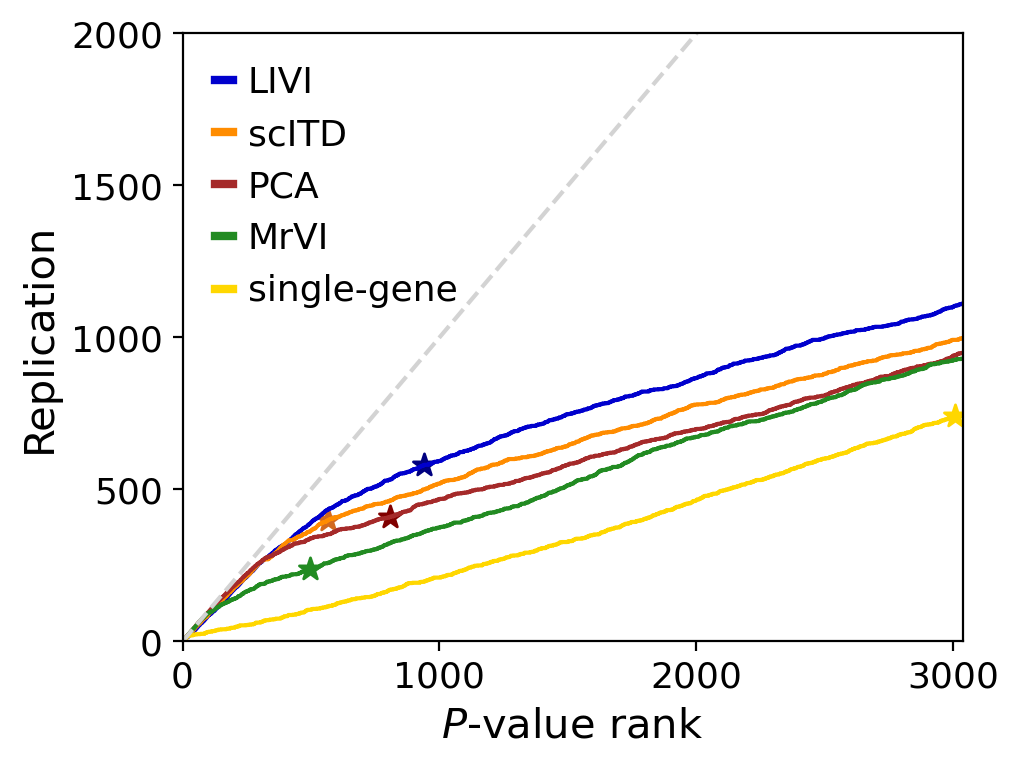

In [93]:
plt.figure(figsize=(5, 4), dpi=100)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted, color="mediumblue", label="LIVI", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_scITD, color="darkorange", label="scITD", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_pca, color="brown", label="PCA", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_MrVI, color="forestgreen", label="MrVI", rasterized=True)
sns.lineplot(x="pvalue_rank", y="Replication_trans", data=SNPs_sorted_gene, color="gold", label="single-gene", rasterized=True)

plt.xlim(0, single_gene_sign.SNP_id.nunique()+30)
plt.ylim(0, 2000)
plt.scatter(x=GxC_effects.SNP_id.nunique(),
            y=SNPs_sorted.sort_values("p_value").iloc[GxC_effects.SNP_id.nunique()]["Replication_trans"],
            c="navy", marker="*", s=70)
plt.scatter(x=scITD.SNP_id.nunique(),
            y=SNPs_sorted_scITD.sort_values("p_value").iloc[scITD.SNP_id.nunique()]["Replication_trans"], 
            c="chocolate", marker="*", s=70)
plt.scatter(x=pca_celltype.SNP_id.nunique(), 
            y=SNPs_sorted_pca.sort_values("p_value").iloc[pca_celltype.SNP_id.nunique()]["Replication_trans"],
            c="maroon", marker="*", s=70)
plt.scatter(x=MrVI.SNP_id.nunique(), 
            y=SNPs_sorted_MrVI.sort_values("p_value").iloc[MrVI.SNP_id.nunique()]["Replication_trans"],
            c="forestgreen", marker="*", s=70)
plt.scatter(x=single_gene_sign.SNP_id.nunique(), 
            y=SNPs_sorted_gene.sort_values("p_value").iloc[single_gene_sign.SNP_id.nunique()-1]["Replication_trans"],
            c="gold", marker="*", s=70)

plt.xlabel("$P$-value rank", fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel("Replication", fontsize=15)
plt.yticks(fontsize=13)

plt.plot(np.arange(0, trans_eQTLGen_sign.snp_id.nunique()), np.arange(0, trans_eQTLGen_sign.snp_id.nunique()), linestyle="--", color="lightgrey")

legend_handles = [
    Line2D([0], [0], color="mediumblue", lw=3, label="LIVI"), 
    Line2D([0], [0], color="darkorange", lw=3, label="scITD"),
    Line2D([0], [0], color="brown", lw=3, label="PCA"),
    Line2D([0], [0], color="forestgreen", lw=3, label="MrVI"),
    Line2D([0], [0], color="gold", lw=3, label="single-gene"),
]
plt.legend(handles=legend_handles, fontsize=13, frameon=False, loc="upper left")

# plt.title("700 factors")
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_ZOOM-IN_each-model-best_plus-TensorQTL.png"), 
            transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_ZOOM-IN_each-model-best_plus-TensorQTL.eps"), 
            transparent=False, bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "Replication_cumsum_vs_pvalue-rank_ZOOM-IN_each-model-best_plus-TensorQTL.pdf"), 
            transparent=True, bbox_inches="tight", dpi=600)

#### QQplot

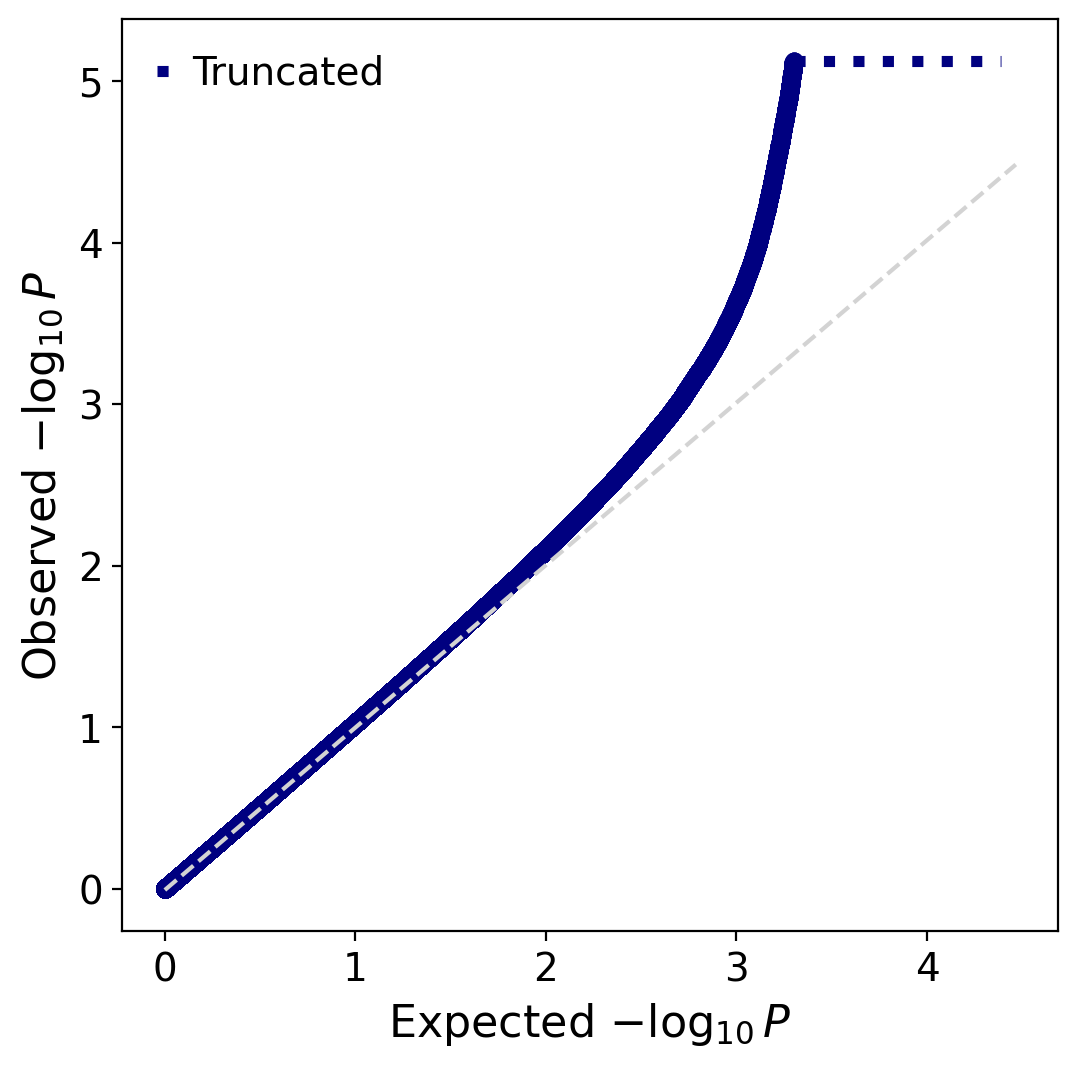

In [34]:
QQplot(GxC_effects_all.p_value, 
       savefig=os.path.join(model_results_dir, "Figures", f"{model}_LMM_QQplot_context-specific-effects.png"), 
       truncate=0.0005)

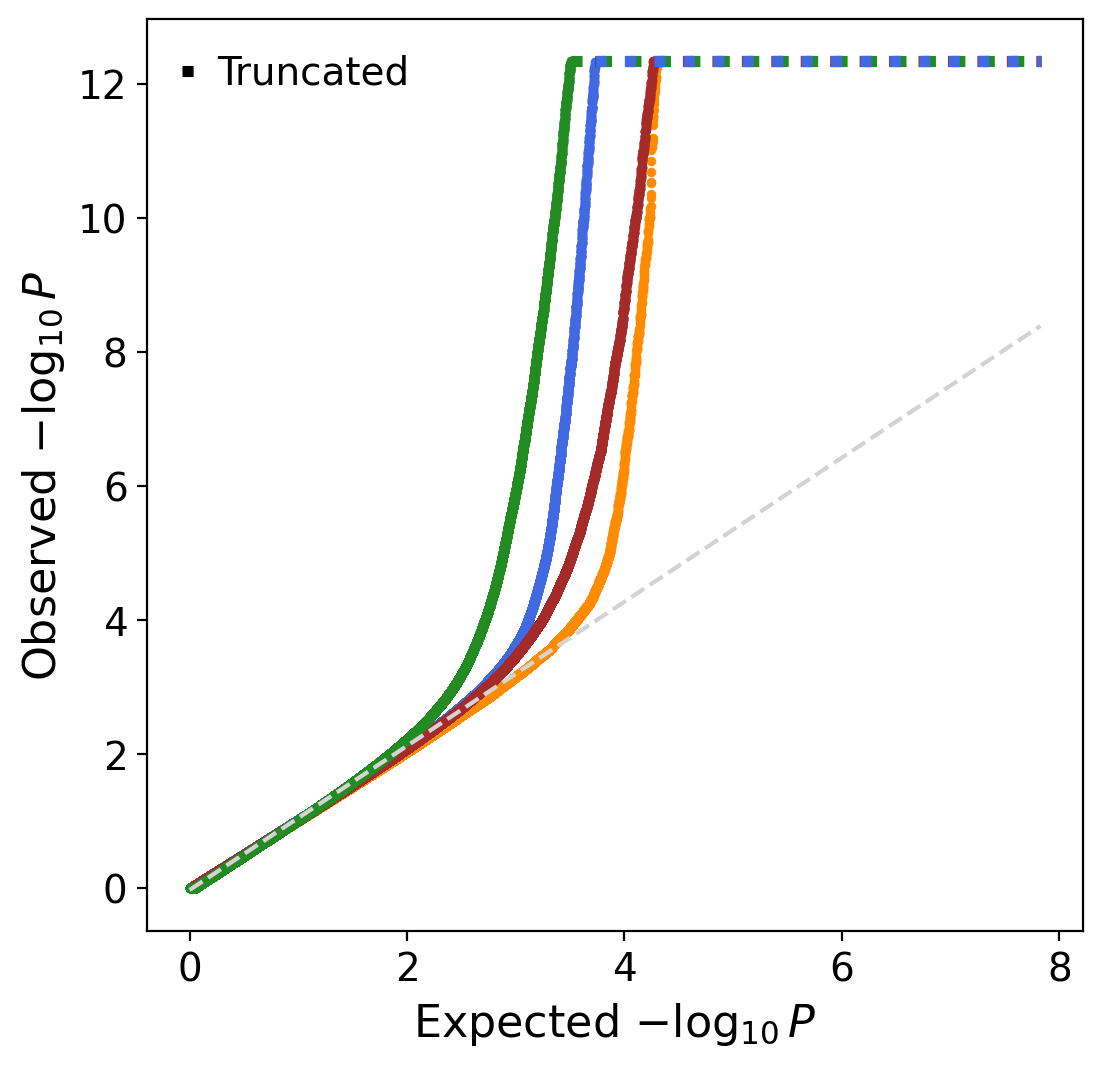

In [36]:
def filter_and_get_x_common(x, y, cutoff_y):
    # Drop points that exceed the common y (i.e. are more significant)
    mask = y <= cutoff_y
    x_filtered = x[mask]
    y_filtered = y[mask]
    # If the very first (most significant) point is above cutoff_y,
    # interpolate between the first two points (or using the full arrays) to get the x at cutoff_y.
    if y[0] > cutoff_y:
        # Since y is descending, reverse the arrays (so they are ascending) for interpolation.
        x_common = np.interp(cutoff_y, y[::-1], x[::-1])
    else:
        x_common = x[0]
    return x_filtered, y_filtered, x_common
    

(osm, osr), _ = probplot(GxC_effects_all.p_value, dist="uniform")
cutoff = int(len(osr) * 0.0001)
truncated_osm = osm[cutoff:]
truncated_osr = osr[cutoff:]
x_LIVI = -np.log10(truncated_osm)
y_LIVI = -np.log10(truncated_osr)

(osm_scITD, osr_scITD), _ = probplot(scITD_all.p_value, dist="uniform")
cutoff = int(len(osr_scITD) * 0.00005)
truncated_osm_scITD = osm_scITD[cutoff:]
truncated_osr_scITD = osr_scITD[cutoff:]
x_scITD = -np.log10(truncated_osm_scITD)
y_scITD = -np.log10(truncated_osr_scITD)

(osm_PCA, osr_PCA), _ = probplot(PCA_celltype_all.p_value, dist="uniform")
cutoff = int(len(osr_PCA) * 0.00001)
truncated_osm_PCA = osm_PCA[cutoff:]
truncated_osr_PCA = osr_PCA[cutoff:]
x_PCA = -np.log10(truncated_osm_PCA)
y_PCA = -np.log10(truncated_osr_PCA)

(osm_MrVI, osr_MrVI), _ = probplot(MrVI_all.p_value, dist="uniform")
cutoff = int(len(osr_MrVI) * 0.0000001)
truncated_osm_MrVI = osm_MrVI[cutoff:]
truncated_osr_MrVI = osr_MrVI[cutoff:]
x_MrVI = -np.log10(truncated_osm_MrVI)
y_MrVI = -np.log10(truncated_osr_MrVI)

# Determine a common truncation level on the y-axis
common_y = min(y_LIVI[0], y_scITD[0], y_PCA[0], y_MrVI[0]) # the first element in each y array is the maximum significance

# Determine a common x-axis end (max x across all methods)
common_x_end = max(x_LIVI.max(), x_scITD.max(), x_PCA.max(), x_MrVI.max())

x_LIVI_filt, y_LIVI_filt, x_common_LIVI = filter_and_get_x_common(x_LIVI, y_LIVI, common_y)
x_scITD_filt, y_scITD_filt, x_common_scITD = filter_and_get_x_common(x_scITD, y_scITD, common_y)
x_PCA_filt, y_PCA_filt, x_common_PCA  = filter_and_get_x_common(x_PCA,  y_PCA,  common_y)
x_MrVI_filt, y_MrVI_filt, x_common_MrVI  = filter_and_get_x_common(x_MrVI,  y_MrVI,  common_y)

plt.figure(figsize=(6,6))
ax = plt.gca()

sns.scatterplot(x=x_LIVI_filt, y=y_LIVI_filt, ax=ax, edgecolor=None, color="royalblue", s=10) # label="LIVI" 
sns.scatterplot(x=x_scITD_filt, y=y_scITD_filt, ax=ax, edgecolor=None, color="darkorange", s=10) # label="scITD"
sns.scatterplot(x=x_PCA_filt, y=y_PCA_filt, ax=ax, edgecolor=None, color="brown", s=10) # label="PCA"
sns.scatterplot(x=x_MrVI_filt, y=y_MrVI_filt, ax=ax, edgecolor=None, color="forestgreen", s=10) # label="MrVI",

# Draw the horizontal “Truncated” dotted line for each method, using its own starting x value, a common x_end and the common_y 
x_end = common_x_end + 1 
ax.hlines(y=common_y, xmin=x_common_LIVI, xmax=x_end, linestyles=":", linewidth=4, color="black", label="Truncated")
ax.hlines(y=common_y, xmin=x_common_scITD, xmax=x_end, linestyles=":", linewidth=4, color="darkorange")
ax.hlines(y=common_y, xmin=x_common_PCA, xmax=x_end, linestyles=":", linewidth=4, color="brown")
ax.hlines(y=common_y, xmin=x_common_MrVI, xmax=x_end, linestyles=":", linewidth=4, color="forestgreen")
ax.hlines(y=common_y, xmin=x_common_LIVI, xmax=x_end, linestyles=":", linewidth=4, color="royalblue")

# Add the diagonal line
b, a_fit = np.polyfit(x_PCA, y_PCA, deg=1)
x_line = np.linspace(0, common_x_end + 1, 100)
ax.plot(x_line, a_fit + b * x_line, c="lightgrey", linestyle="--")

ax.set(xlabel=r"Expected $-\log_{10} P$", ylabel=r"Observed $-\log_{10} P$")
ax.legend(loc="upper left", fontsize=14, frameon=False, markerscale=2)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)

plt.savefig(os.path.join(model_results_dir, "Figures", "QQplot_Benchmark_each-model-best.png"), 
            transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "QQplot_Benchmark_each-model-best.eps"), 
            transparent=False, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "QQplot_Benchmark_each-model-best.pdf"), 
            transparent=True, bbox_inches="tight", dpi=600)

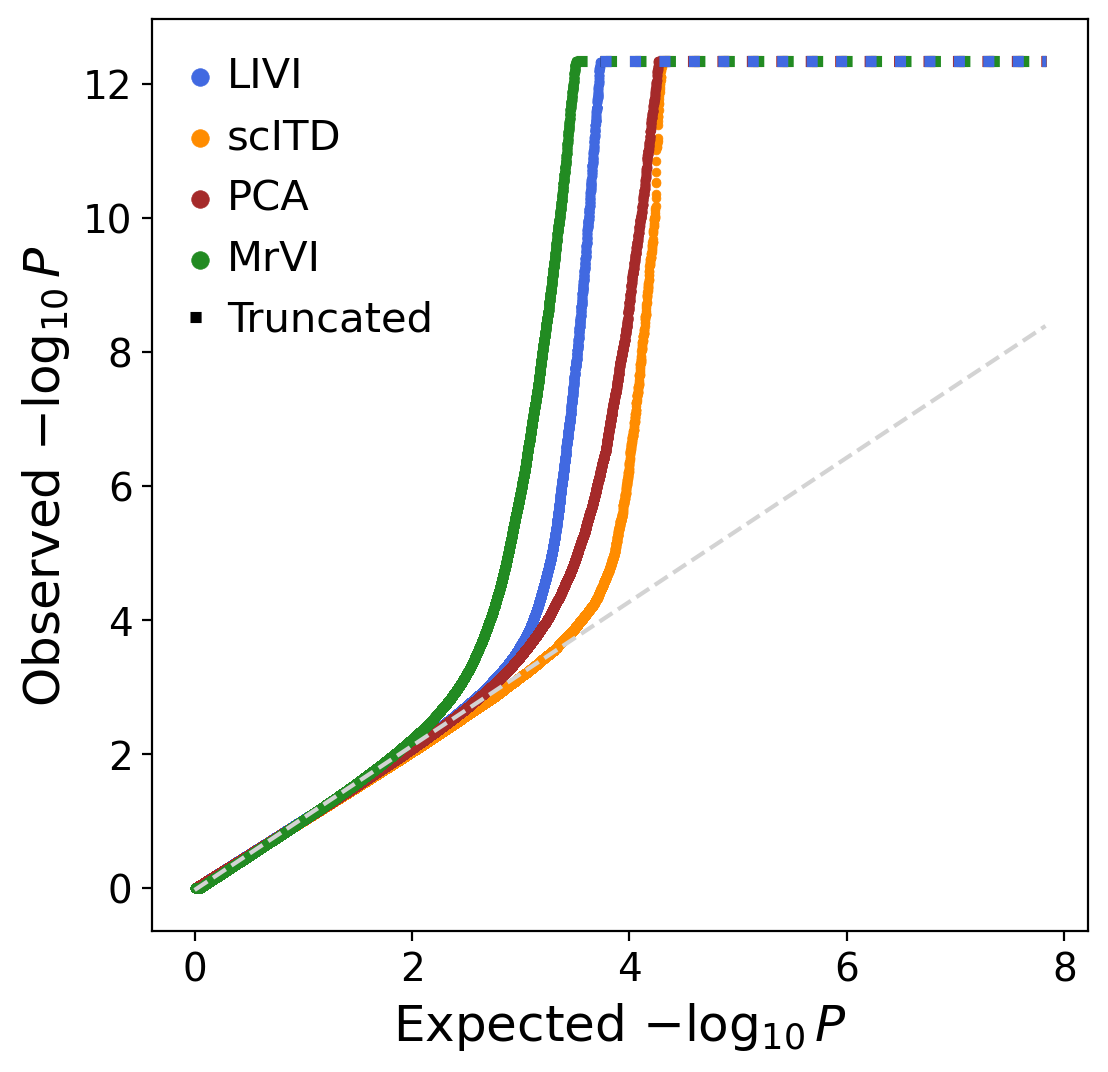

In [38]:
def filter_and_get_x_common(x, y, cutoff_y):
    # Drop points that exceed the common y (i.e. are more significant)
    mask = y <= cutoff_y
    x_filtered = x[mask]
    y_filtered = y[mask]
    # If the very first (most significant) point is above cutoff_y,
    # interpolate between the first two points (or using the full arrays) to get the x at cutoff_y.
    if y[0] > cutoff_y:
        # Since y is descending, reverse the arrays (so they are ascending) for interpolation.
        x_common = np.interp(cutoff_y, y[::-1], x[::-1])
    else:
        x_common = x[0]
    return x_filtered, y_filtered, x_common
    

(osm, osr), _ = probplot(GxC_effects_all.p_value, dist="uniform")
cutoff = int(len(osr) * 0.0001)
truncated_osm = osm[cutoff:]
truncated_osr = osr[cutoff:]
x_LIVI = -np.log10(truncated_osm)
y_LIVI = -np.log10(truncated_osr)

(osm_scITD, osr_scITD), _ = probplot(scITD_all.p_value, dist="uniform")
cutoff = int(len(osr_scITD) * 0.00005)
truncated_osm_scITD = osm_scITD[cutoff:]
truncated_osr_scITD = osr_scITD[cutoff:]
x_scITD = -np.log10(truncated_osm_scITD)
y_scITD = -np.log10(truncated_osr_scITD)

(osm_PCA, osr_PCA), _ = probplot(PCA_celltype_all.p_value, dist="uniform")
cutoff = int(len(osr_PCA) * 0.00001)
truncated_osm_PCA = osm_PCA[cutoff:]
truncated_osr_PCA = osr_PCA[cutoff:]
x_PCA = -np.log10(truncated_osm_PCA)
y_PCA = -np.log10(truncated_osr_PCA)

(osm_MrVI, osr_MrVI), _ = probplot(MrVI_all.p_value, dist="uniform")
cutoff = int(len(osr_MrVI) * 0.0000001)
truncated_osm_MrVI = osm_MrVI[cutoff:]
truncated_osr_MrVI = osr_MrVI[cutoff:]
x_MrVI = -np.log10(truncated_osm_MrVI)
y_MrVI = -np.log10(truncated_osr_MrVI)

# Determine a common truncation level on the y-axis
common_y = min(y_LIVI[0], y_scITD[0], y_PCA[0], y_MrVI[0]) # the first element in each y array is the maximum significance

# Determine a common x-axis end (max x across all methods)
common_x_end = max(x_LIVI.max(), x_scITD.max(), x_PCA.max(), x_MrVI.max())

x_LIVI_filt, y_LIVI_filt, x_common_LIVI = filter_and_get_x_common(x_LIVI, y_LIVI, common_y)
x_scITD_filt, y_scITD_filt, x_common_scITD = filter_and_get_x_common(x_scITD, y_scITD, common_y)
x_PCA_filt, y_PCA_filt, x_common_PCA  = filter_and_get_x_common(x_PCA,  y_PCA,  common_y)
x_MrVI_filt, y_MrVI_filt, x_common_MrVI  = filter_and_get_x_common(x_MrVI,  y_MrVI,  common_y)

plt.figure(figsize=(6,6))
ax = plt.gca()

sns.scatterplot(x=x_LIVI_filt, y=y_LIVI_filt, ax=ax, edgecolor=None, color="royalblue", s=10, label="LIVI") 
sns.scatterplot(x=x_scITD_filt, y=y_scITD_filt, ax=ax, edgecolor=None, color="darkorange", s=10, label="scITD")
sns.scatterplot(x=x_PCA_filt, y=y_PCA_filt, ax=ax, edgecolor=None, color="brown", s=10, label="PCA")
sns.scatterplot(x=x_MrVI_filt, y=y_MrVI_filt, ax=ax, edgecolor=None, color="forestgreen", s=10, label="MrVI")

# Draw the horizontal “data not shown” dotted line for each method, using its own starting x value, a common x_end and the common_y 
x_end = common_x_end + 1 
ax.hlines(y=common_y, xmin=x_common_LIVI, xmax=x_end, linestyles=":", linewidth=4, color="black", label="Truncated")
ax.hlines(y=common_y, xmin=x_common_scITD, xmax=x_end, linestyles=":", linewidth=4, color="darkorange")
ax.hlines(y=common_y, xmin=x_common_PCA, xmax=x_end, linestyles=":", linewidth=4, color="brown")
ax.hlines(y=common_y, xmin=x_common_MrVI, xmax=x_end, linestyles=":", linewidth=4, color="forestgreen")
ax.hlines(y=common_y, xmin=x_common_LIVI, xmax=x_end, linestyles=":", linewidth=4, color="royalblue")

# Add the diagonal reference line
b, a_fit = np.polyfit(x_PCA, y_PCA, deg=1)
x_line = np.linspace(0, common_x_end + 1, 100)
ax.plot(x_line, a_fit + b * x_line, c="lightgrey", linestyle="--")

ax.set(xlabel=r"Expected $-\log_{10} P$", ylabel=r"Observed $-\log_{10} P$")
ax.legend(loc="upper left", fontsize=15, frameon=False, markerscale=2)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

plt.savefig(os.path.join(model_results_dir, "Figures", "QQplot_Benchmark_each-model-best_with-legend.png"), 
            transparent=True, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "QQplot_Benchmark_each-model-best_with-legend.eps"), 
            transparent=False, bbox_inches="tight", dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", "QQplot_Benchmark_each-model-best_with-legend.pdf"), 
            transparent=True, bbox_inches="tight", dpi=600)

In [125]:
GxC_effects_chr6 = GxC_effects_chr6.assign(mlog10p = - np.log10(GxC_effects_chr6.p_value))

In [114]:
f"Percentage of discovered SNPs that are located on chromosome 6: {np.round(GxC_effects_chr6.SNP_id.nunique()/GxC_effects.SNP_id.nunique(), 3)*100}"

'Percentage of discovered SNPs that are located on chromosome 6: 51.1'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


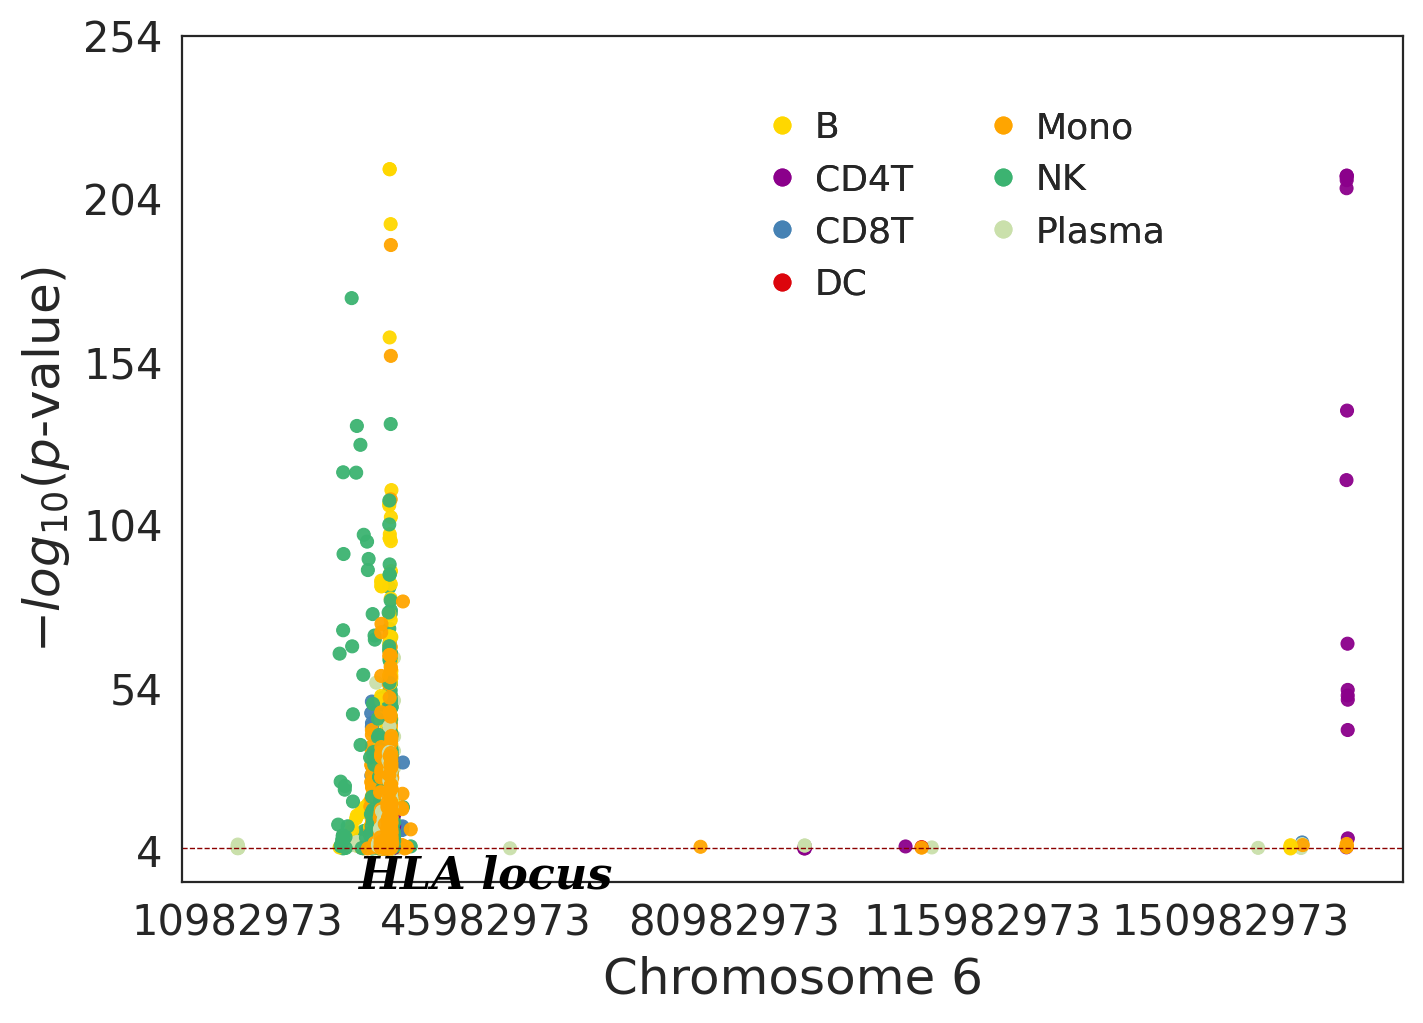

In [130]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), constrained_layout=True, dpi=100)

sns.scatterplot(data=GxC_effects_chr6, x="SNP_pos", y="mlog10p", hue="Celltypes",
                alpha=0.95, s=22, palette=major_celltype_colors,
                edgecolor="face", ax=axs, rasterized=True)

# axs.set_xticks(sorted(HLA_loc_summary.gene_start.tolist()+HLA_loc_summary.gene_end.tolist()))
# axs.set_xticklabels(HLA_loc_summary.gene_name, fontsize=10, rotation=0)
x_ticks = np.arange(int(GxC_effects_chr6.SNP_pos.min()), int(GxC_effects_chr6.SNP_pos.max()), 3.5e7, dtype=int)
axs.set_xticks(x_ticks)
axs.set_xticklabels(x_ticks, fontsize=15)
axs.set_xlabel("Chromosome 6", fontsize=18)

y_ticks = np.arange(int(GxC_effects_chr6.mlog10p.min()), int(GxC_effects_chr6.mlog10p.max()), 50)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)

axs.axhline(y=-np.log10(GxC_effects.p_value.max()), color="darkred", linestyle="dashed", linewidth=0.5)

legend_hue_handles, legend_hue_labels = (axs.get_legend_handles_labels()[0],
                                         axs.get_legend_handles_labels()[1])

# Sort labels alphabetically and reorder handles accordingly
sorted_indices = sorted(range(len(legend_hue_labels)), key=lambda k: legend_hue_labels[k])
legend_hue_handles = [legend_hue_handles[i] for i in sorted_indices]
legend_hue_labels = sorted(legend_hue_labels)

legend_hue = axs.legend(title="", labels=legend_hue_labels, handles = legend_hue_handles, frameon=False, 
                        loc="upper left", handlelength=1, bbox_transform=axs.transAxes, ncol=2, markerscale=1.3,
                        fontsize=13, bbox_to_anchor=[0.45,0.95])
axs.add_artist(legend_hue)


axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-A"].gene_start.iloc[0]-2e6, -3.8, "HLA locus", va="center", 
         fontdict={"fontsize":16, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-B"].gene_start.iloc[0]-150000, -4.8, "HLA-B", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-C"].gene_start.iloc[0]-150000, -7, "HLA-C", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DR"].gene_start.iloc[0]-150000, -4.8, "HLA-DR", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DQ"].gene_start.iloc[0]-150000, -4.8, "HLA-DQ", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DO"].gene_start.iloc[0]-150000, -4.8, "HLA-DO", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DM"].gene_start.iloc[0]-150000, -4.8, "HLA-DM", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DP"].gene_start.iloc[0]-150000, -4.8, "HLA-DP", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})


plt.savefig(os.path.join(model_results_dir, "Figures", "15PCs_after_aggregation_BH_CxG-effects_Manhattan-plot_chromosome6_major-celltypes.png"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "15PCs_after_aggregation_BH_CxG-effects_Manhattan-plot_chromosome6_major-celltypes.eps"), 
            transparent=True, dpi=500, bbox_inches="tight")

In [131]:
GxC_effects_all = GxC_effects_all.assign(Celltypes = GxC_effects_all.apply(lambda x: U_ct[x.Factor], axis=1))
GxC_effects_all = GxC_effects_all.explode("Celltypes")
GxC_effects_all.head()

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,Storey_qvals,BH_corrected_pval,is_significant,m_log10_Sqval,m_log10_BHpval,m_log10_pvalue,SNP_chrom,SNP_pos,SNP_position_offset,position2plot,mean_plot_position,Celltypes,fQTL
0,U_Factor1,1:1247494,-0.069020,0.035374,0.050816,C,0.911732,0.923008,False,0.040133,0.034795,1.294000,1,1247494,0.0,1247494.0,1.258506e+08,Mono NC,1:1247494__U_Factor1
1,U_Factor633,1:161946727,-0.036913,0.056710,0.515064,A,0.976590,0.988668,False,0.010288,0.004950,0.288139,1,161946727,0.0,161946727.0,1.258506e+08,CD4 NC,1:161946727__U_Factor633
2,U_Factor633,1:161540857,0.068150,0.061489,0.267566,T,0.962548,0.974453,False,0.016577,0.011239,0.572570,1,161540857,0.0,161540857.0,1.258506e+08,CD4 NC,1:161540857__U_Factor633
3,U_Factor633,1:161485259,0.031924,0.062942,0.611990,G,0.979896,0.992015,False,0.008820,0.003482,0.213256,1,161485259,0.0,161485259.0,1.258506e+08,CD4 NC,1:161485259__U_Factor633
4,U_Factor633,1:161479745,-0.011467,0.040602,0.777615,G,0.984359,0.996533,False,0.006846,0.001508,0.109236,1,161479745,0.0,161479745.0,1.258506e+08,CD4 NC,1:161479745__U_Factor633


In [132]:
GxC_effects.drop(columns="Celltypes", inplace=True)
GxC_effects = GxC_effects.merge(
    GxC_effects_all.filter(["fQTL", "Celltypes"]),
    on="fQTL", how="left")
GxC_effects.head()

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue,fQTL,SNP_chrom,SNP_pos,Celltypes
0,U_Factor1,14:81884515,0.128089,0.029964,1.747683e-05,G,3.124271e-02,14:81884515__U_Factor1,14,81884515,Mono NC
1,U_Factor5,19:58963530,0.585091,0.071890,1.218412e-16,G,8.928493e-13,19:58963530__U_Factor5,19,58963530,None
2,U_Factor11,6:161111700,1.012741,0.201583,4.265749e-07,C,1.083497e-03,6:161111700__U_Factor11,6,161111700,CD8 S100B
3,U_Factor12,3:39555580,0.505091,0.055674,1.831975e-20,A,1.759641e-16,3:39555580__U_Factor12,3,39555580,Plasma
4,U_Factor14,2:232579379,-0.201663,0.025578,1.112895e-15,G,7.537058e-12,2:232579379__U_Factor14,2,232579379,B IN


In [133]:
GxC_effects_chr6 = GxC_effects.loc[GxC_effects.SNP_chrom == 6]
GxC_effects_chr6 = GxC_effects_chr6.assign(mlog10p = - np.log10(GxC_effects_chr6.p_value))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


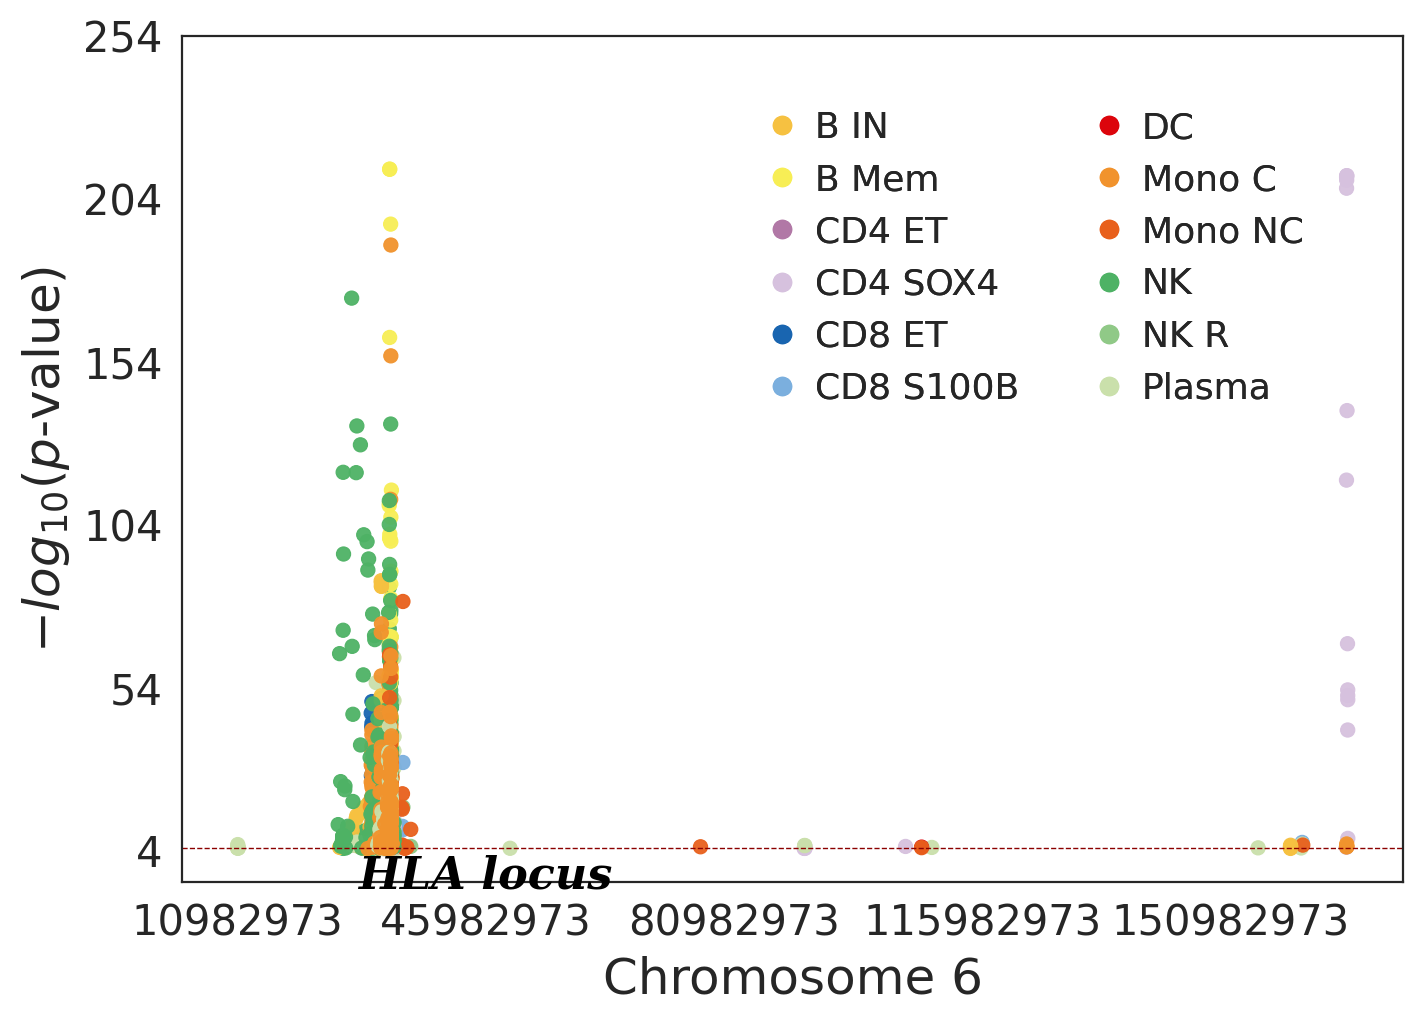

In [134]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), constrained_layout=True, dpi=100)

sns.scatterplot(data=GxC_effects_chr6, x="SNP_pos", y="mlog10p", hue="Celltypes",
                alpha=0.95, s=26, palette=cell_label_colors,
                edgecolor="face", ax=axs, rasterized=True,)

# axs.set_xticks(sorted(HLA_loc_summary.gene_start.tolist()+HLA_loc_summary.gene_end.tolist()))
# axs.set_xticklabels(HLA_loc_summary.gene_name, fontsize=10, rotation=0)
x_ticks = np.arange(int(GxC_effects_chr6.SNP_pos.min()), int(GxC_effects_chr6.SNP_pos.max()), 3.5e7, dtype=int)
axs.set_xticks(x_ticks)
axs.set_xticklabels(x_ticks, fontsize=15)
axs.set_xlabel("Chromosome 6", fontsize=18)

y_ticks = np.arange(int(GxC_effects_chr6.mlog10p.min()), int(GxC_effects_chr6.mlog10p.max()), 50)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)

axs.axhline(y=-np.log10(GxC_effects.p_value.max()), color="darkred", linestyle="dashed", linewidth=0.5)

legend_hue_handles, legend_hue_labels = (axs.get_legend_handles_labels()[0],
                                         axs.get_legend_handles_labels()[1])

# Sort labels alphabetically and reorder handles accordingly
sorted_indices = sorted(range(len(legend_hue_labels)), key=lambda k: legend_hue_labels[k])
legend_hue_handles = [legend_hue_handles[i] for i in sorted_indices]
legend_hue_labels = sorted(legend_hue_labels)

legend_hue = axs.legend(title="", labels=legend_hue_labels, handles = legend_hue_handles, frameon=False, 
                        loc="upper left", handlelength=1, bbox_transform=axs.transAxes, ncol=2, markerscale=1.3,
                        fontsize=13, bbox_to_anchor=[0.45,0.95])
axs.add_artist(legend_hue)


axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-A"].gene_start.iloc[0]-2e6, -3.8, "HLA locus", va="center", 
         fontdict={"fontsize":16, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-B"].gene_start.iloc[0]-150000, -4.8, "HLA-B", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-C"].gene_start.iloc[0]-150000, -7, "HLA-C", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DR"].gene_start.iloc[0]-150000, -4.8, "HLA-DR", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DQ"].gene_start.iloc[0]-150000, -4.8, "HLA-DQ", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DO"].gene_start.iloc[0]-150000, -4.8, "HLA-DO", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DM"].gene_start.iloc[0]-150000, -4.8, "HLA-DM", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})
# axs.text(HLA_summary.loc[HLA_summary.gene_name == "HLA-DP"].gene_start.iloc[0]-150000, -4.8, "HLA-DP", va="center", 
#          fontdict={"fontsize":12, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})

# plt.savefig(os.path.join(model_results_dir, "Figures", f"{os.path.basename(model_results_dir)}_CxG-effects_Manhattan-plot_chromosome6_celltypes.png"), 
#             transparent=True, dpi=500, bbox_inches="tight")
# plt.savefig(os.path.join(model_results_dir, "Figures", f"{os.path.basename(model_results_dir)}_CxG-effects_Manhattan-plot_chromosome6_celltypes.png"), 
#             transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "15PCs_after_aggregation_BH_GxC-effects_Manhattan-plot_chromosome6_celltypes_2.png"), 
            transparent=False, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "15PCs_after_aggregation_BH_GxC-effects_Manhattan-plot_chromosome6_celltypes_2.eps"), 
            transparent=False, dpi=500, bbox_inches="tight")

#### SNPs discovered only by LIVI

In [29]:
hg_mapping = pd.read_csv("/data/danai/Data/OneK1K/trans-eQTL-Gen_liftOver_results.tsv", sep="\t")
hg_mapping.head()

,SNP_id_hg38,SNP_id_hg19
0,1:1312114,1:1247494
1,1:1962845,1:1894284
2,1:2137733,1:2069172
3,1:2214726,1:2146165
4,1:2302522,1:2233961


In [30]:
rsids = pd.read_csv("/data/danai/Data/OneK1K/ALL_chroms.dose.filtered.R2_0.8_001MAF_HWE_trans-eQTLGen_rsIDs.bim",
                    sep="\t", index_col=False, names=["chr", "rsID", "bla", "position", "a0", "a1"])
rsids = rsids.assign(SNP_id_hg19 = rsids.chr.astype(str) + ":" + rsids.position.astype(str))
rsids.head()

,chr,rsID,bla,position,a0,a1,SNP_id_hg19
0,1,1:1247494,0,1247494,T,C,1:1247494
1,1,rs4648739,0,1894284,C,T,1:1894284
2,1,rs425277,0,2069172,T,C,1:2069172
3,1,rs78265569,0,2146165,A,C,1:2146165
4,1,rs11576356,0,2233961,A,G,1:2233961


In [31]:
snp_mapping = hg_mapping.merge(rsids.filter(["SNP_id_hg19", "rsID", "a0", "a1"]), how="left", on="SNP_id_hg19")
snp_mapping = snp_mapping.drop_duplicates()
snp_mapping.head()

,SNP_id_hg38,SNP_id_hg19,rsID,a0,a1
0,1:1312114,1:1247494,1:1247494,T,C
1,1:1962845,1:1894284,rs4648739,C,T
2,1:2137733,1:2069172,rs425277,T,C
3,1:2214726,1:2146165,rs78265569,A,C
4,1:2302522,1:2233961,rs11576356,A,G


In [32]:
trans_fSNPs_only_LIVI = pd.read_csv(
    os.path.join(model_results_dir, "trans-fSNPs_only-LIVI.tsv"),
    sep="\t", index_col=False)
trans_fSNPs_only_LIVI

,SNP_id,Factor,fQTL,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue,SNP_chrom,SNP_pos,mlog10_pval
0,18:8323984,U_Factor19,18:8323984__U_Factor19,0.242943,0.055565,1.114032e-05,A,0.021257,18,8323984,4.953102
1,5:32694942,U_Factor21,5:32694942__U_Factor21,-0.273905,0.062873,1.198885e-05,C,0.022690,5,32694942,4.921222
2,10:99136403,U_Factor25,10:99136403__U_Factor25,0.186891,0.042861,1.177085e-05,C,0.022316,10,99136403,4.929192
3,7:17442679,U_Factor39,7:17442679__U_Factor39,0.176963,0.041870,2.176661e-05,A,0.037558,7,17442679,4.662209
4,6:10982973,U_Factor44,6:10982973__U_Factor44,-0.224585,0.053523,2.497140e-05,T,0.042181,6,10982973,4.602557
...,...,...,...,...,...,...,...,...,...,...,...
349,6:167406633,U_Factor683,6:167406633__U_Factor683,0.342276,0.076638,7.152663e-06,C,0.014407,6,167406633,5.145532
350,7:100512119,U_Factor686,7:100512119__U_Factor686,-0.159172,0.037500,2.005796e-05,C,0.035081,7,100512119,4.697713
351,10:70982941,U_Factor690,10:70982941__U_Factor690,0.339352,0.065385,1.730005e-07,T,0.000470,10,70982941,6.761953
352,17:49244747,U_Factor691,17:49244747__U_Factor691,-0.280535,0.067103,2.675186e-05,G,0.044668,17,49244747,4.572646


In [33]:
trans_fSNPs_only_LIVI = trans_fSNPs_only_LIVI.merge(snp_mapping.rename(columns={"SNP_id_hg19":"SNP_id"}).filter(["SNP_id", "rsID"]), on="SNP_id", how="left")
trans_fSNPs_only_LIVI.head()

,SNP_id,Factor,fQTL,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue,SNP_chrom,SNP_pos,mlog10_pval,rsID
0,18:8323984,U_Factor19,18:8323984__U_Factor19,0.242943,0.055565,0.000011,A,0.021257,18,8323984,4.953102,18:8323984
1,5:32694942,U_Factor21,5:32694942__U_Factor21,-0.273905,0.062873,0.000012,C,0.022690,5,32694942,4.921222,rs7731703
2,10:99136403,U_Factor25,10:99136403__U_Factor25,0.186891,0.042861,0.000012,C,0.022316,10,99136403,4.929192,rs61863818
3,7:17442679,U_Factor39,7:17442679__U_Factor39,0.176963,0.041870,0.000022,A,0.037558,7,17442679,4.662209,7:17442679
4,6:10982973,U_Factor44,6:10982973__U_Factor44,-0.224585,0.053523,0.000025,T,0.042181,6,10982973,4.602557,rs3734398


In [34]:
GxC_effects_all = GxC_effects_all.assign(
    LIVI_only = GxC_effects_all.apply(lambda x: x.SNP_id in trans_fSNPs_only_LIVI.SNP_id.unique().tolist(), axis=1)
)

GxC_effects_all.LIVI_only.sum()

205800

In [35]:
GxC_effects_all = GxC_effects_all.merge(snp_mapping.rename(columns={"SNP_id_hg19":"SNP_id"}).filter(["SNP_id", "rsID"]), on="SNP_id", how="left")
GxC_effects_all.head()

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,fQTL,Storey_qvals,BH_corrected_pval,is_significant,...,m_log10_BHpval,m_log10_pvalue,SNP_chrom,SNP_pos,SNP_position_offset,position2plot,mean_plot_position,Celltypes,LIVI_only,rsID
0,U_Factor1,1:1247494,-0.069020,0.035374,0.050816,C,1:1247494__U_Factor1,0.911732,0.923008,False,...,0.034795,1.294000,1,1247494,0.0,1247494.0,1.258506e+08,Mono NC,False,1:1247494
1,U_Factor633,1:161946727,-0.036913,0.056710,0.515064,A,1:161946727__U_Factor633,0.976590,0.988668,False,...,0.004950,0.288139,1,161946727,0.0,161946727.0,1.258506e+08,CD4 NC,False,rs2340727
2,U_Factor633,1:161540857,0.068150,0.061489,0.267566,T,1:161540857__U_Factor633,0.962548,0.974453,False,...,0.011239,0.572570,1,161540857,0.0,161540857.0,1.258506e+08,CD4 NC,False,rs67418890
3,U_Factor633,1:161485259,0.031924,0.062942,0.611990,G,1:161485259__U_Factor633,0.979896,0.992015,False,...,0.003482,0.213256,1,161485259,0.0,161485259.0,1.258506e+08,CD4 NC,False,rs17400517
4,U_Factor633,1:161479745,-0.011467,0.040602,0.777615,G,1:161479745__U_Factor633,0.984359,0.996533,False,...,0.001508,0.109236,1,161479745,0.0,161479745.0,1.258506e+08,CD4 NC,False,1:161479745


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


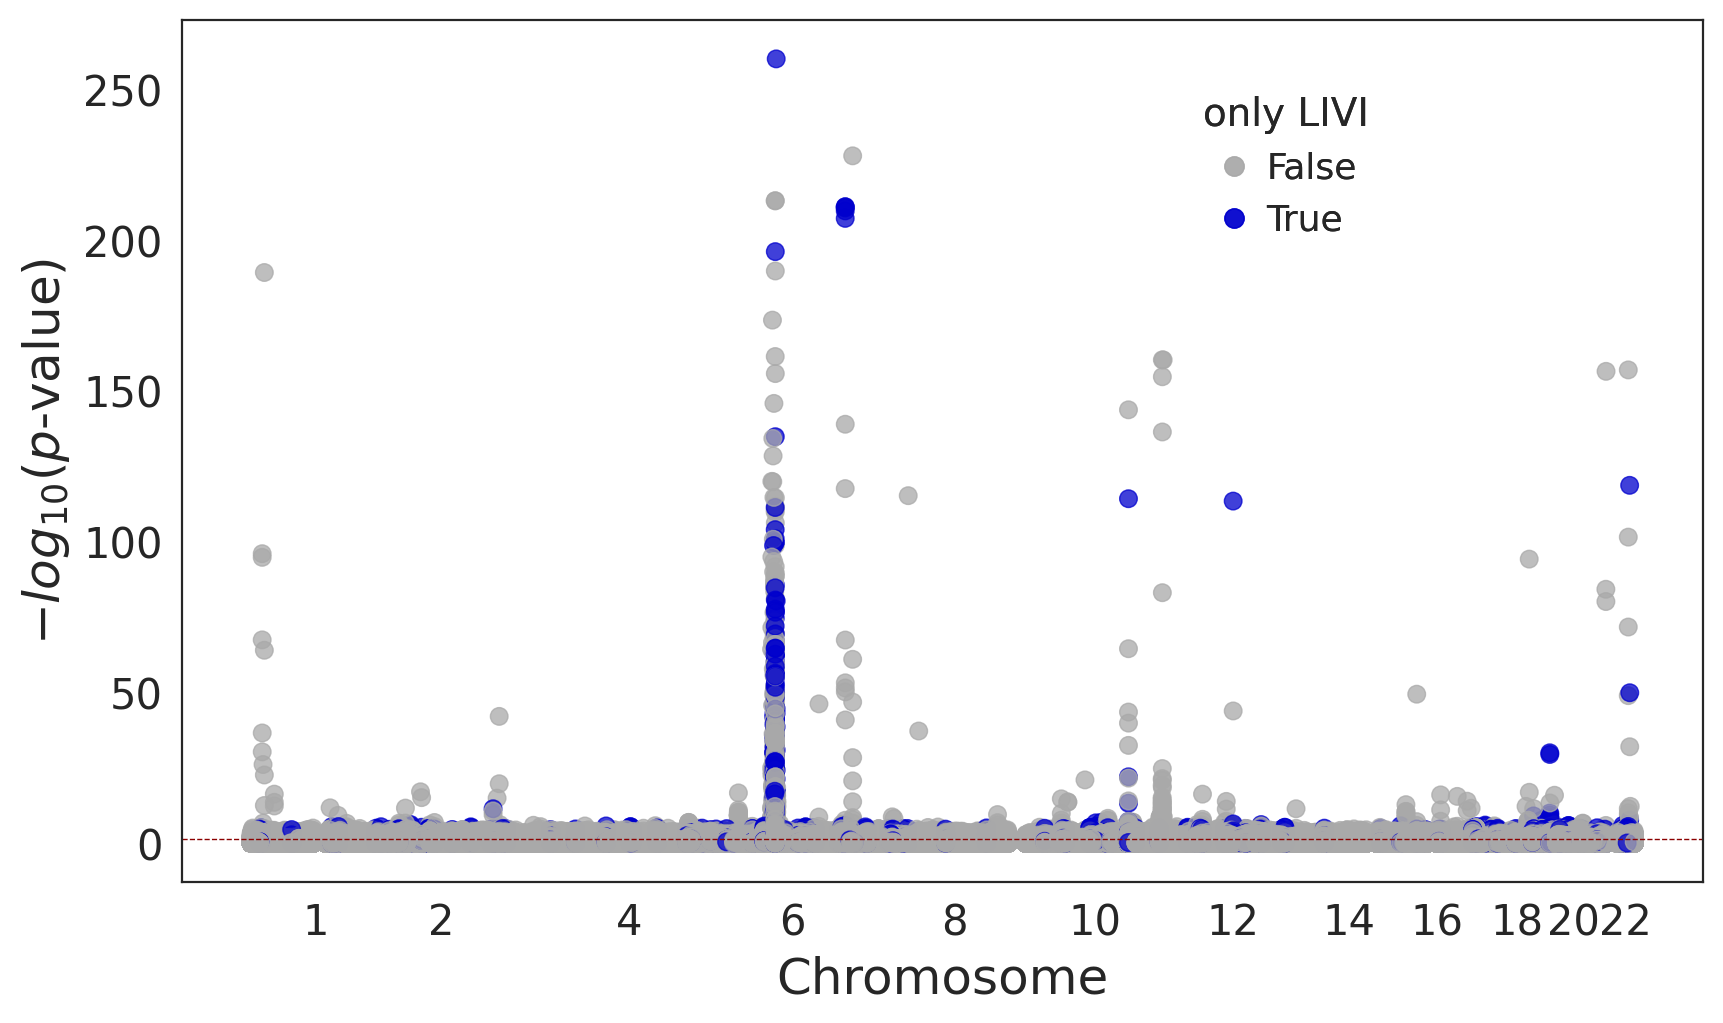

In [181]:
sns.set_style("white")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 5), constrained_layout=True)

sns.scatterplot(data=GxC_effects_all, x="position2plot", y="m_log10_pvalue", hue="LIVI_only",
                alpha=0.75, s=40, palette=["darkgrey", "mediumblue"], edgecolor="face", ax=axs,
                rasterized=True, legend=True)

axs.set_xticks(tmp["mean_plot_position"])
axs.set_xticklabels(tmp["SNP_chrom"], fontsize=15, rotation=0)
axs.set_xlabel("Chromosome", fontsize=18)

y_ticks = np.arange(int(GxC_effects_all.m_log10_pvalue.min()), int(GxC_effects_all.m_log10_pvalue.max()), 50)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)
# significance threshold
axs.axhline(y=-np.log10(cut_off), color="darkred", linestyle="dashed", linewidth=0.5)

legend_hue_handles, legend_hue_labels = (axs.get_legend_handles_labels()[0],
                                         axs.get_legend_handles_labels()[1])

legend_hue = axs.legend(title="only LIVI", labels=legend_hue_labels, handles = legend_hue_handles, frameon=False, 
                        loc="upper left", handlelength=1, bbox_transform=axs.transAxes, ncol=1, markerscale=1.1,
                        title_fontsize=14, fontsize=13, bbox_to_anchor=[0.65,0.95])
axs.add_artist(legend_hue)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI.png"), 
            transparent=True, dpi=800, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI.eps"), 
            transparent=True, dpi=800, bbox_inches="tight")

In [46]:
# snps2annotate = ["6:29789171", "6:31018407", "11:128391937", "8:22966769"]
# snps2annotate_rs = ["rs1610677", "rs2517532", "rs61907765", "rs12550612"]
# snps2annotate = ["6:29789171", "11:128391937", "8:22966769"]
# snps2annotate_rs = ["rs1610677", "rs61907765", "rs12550612"]
snps2annotate = ["6:31018407"]
snps2annotate_rs = ["rs2517532"]

In [52]:
factors4snps = ["U_Factor287", "U_Factor246", "U_Factor693", "U_Factor232"]
# factors4snps = ["U_Factor287", "U_Factor693", "U_Factor232"]

In [53]:
GxC_effects_all.rsID.replace(dict(zip(snps2annotate, snps2annotate_rs)), inplace=True)

In [54]:
GxC_effects_all.loc[GxC_effects_all.rsID.isin(snps2annotate_rs)].rsID.unique()

array(['rs2517532'], dtype=object)

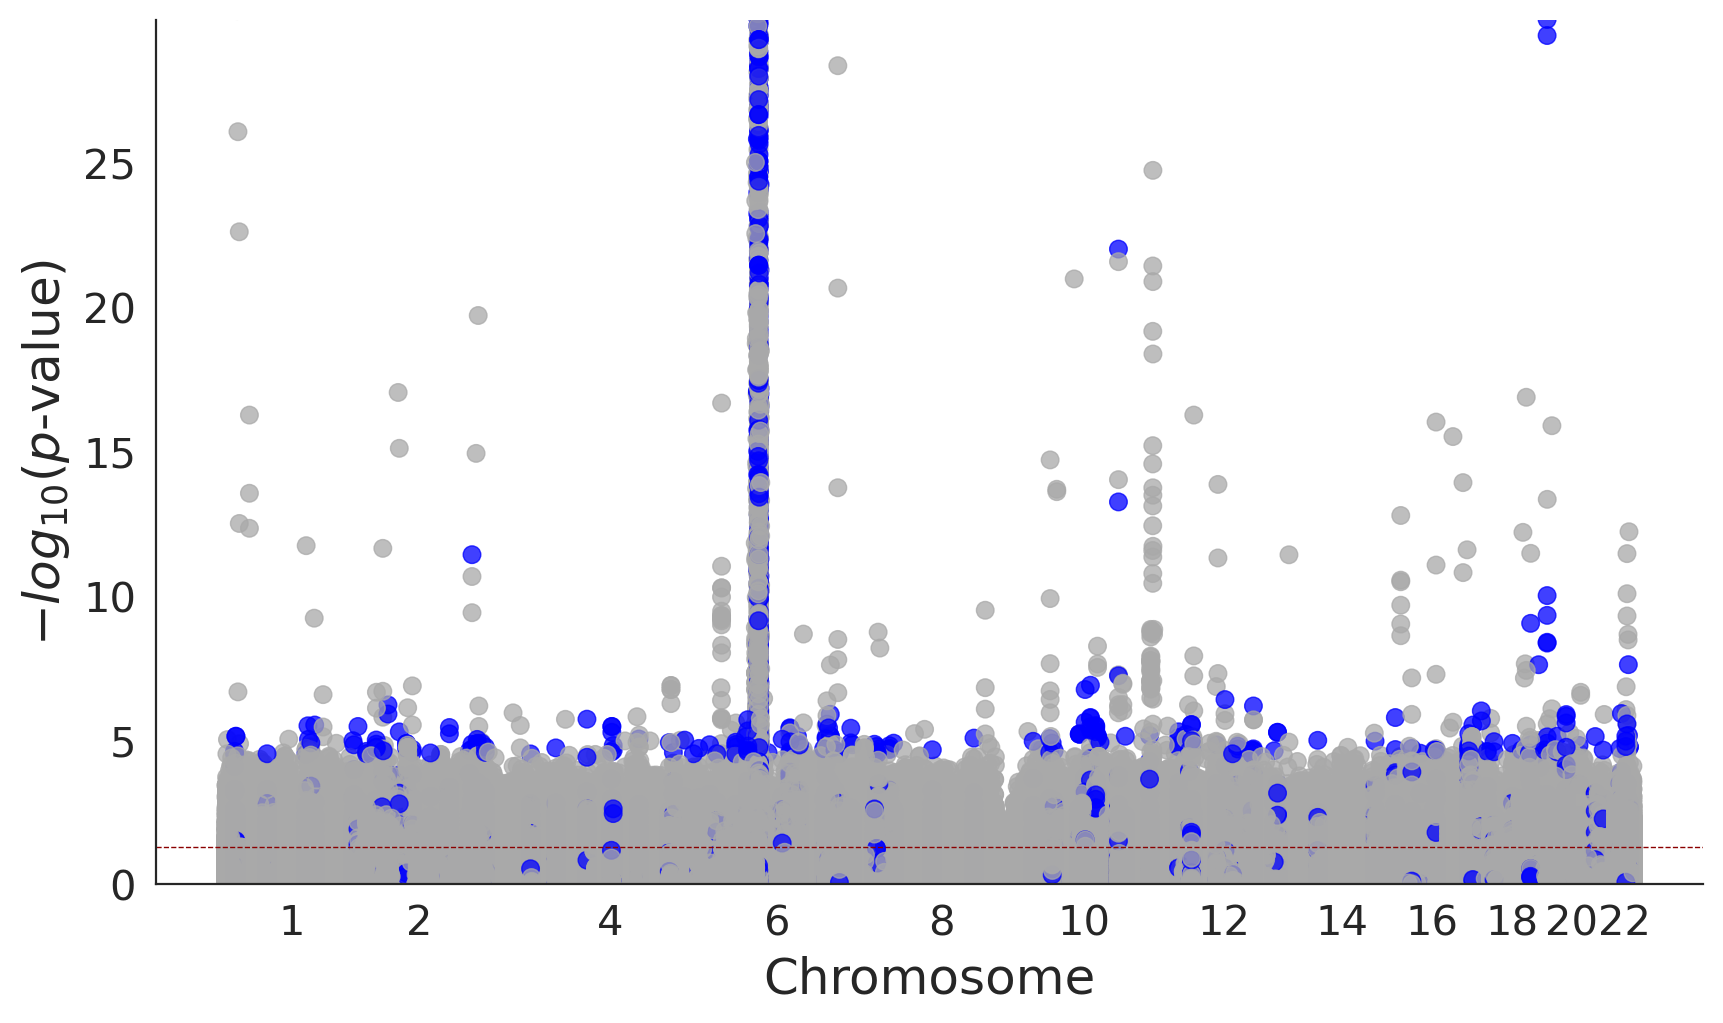

In [54]:
sns.set_style("white")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 5), constrained_layout=True)

sns.scatterplot(data=GxC_effects_all, x="position2plot", y="m_log10_pvalue", hue="LIVI_only",
                alpha=0.75, s=40, palette=["darkgrey", "blue"], edgecolor="face", ax=axs,
                rasterized=True, legend=False)

axs.set_xticks(tmp["mean_plot_position"])
axs.set_xticklabels(tmp["SNP_chrom"], fontsize=15, rotation=0)
axs.set_xlabel("Chromosome", fontsize=18)

# y_ticks = np.arange(int(GxC_effects_all_min_pval.m_log10_pvalue.min()), int(GxC_effects_all_min_pval.m_log10_pvalue.max()), 50)
axs.set_ylim(0, 30)
y_ticks = np.arange(0, 30, 5)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)
# significance threshold
axs.axhline(y=-np.log10(cut_off), color="darkred", linestyle="dashed", linewidth=0.5)

# legend_hue_handles, legend_hue_labels = (axs.get_legend_handles_labels()[0],
#                                          axs.get_legend_handles_labels()[1])

# legend_hue = axs.legend(title="only LIVI", labels=legend_hue_labels, handles = legend_hue_handles, frameon=False, 
#                         loc="upper left", handlelength=1, bbox_transform=axs.transAxes, ncol=1, markerscale=1.1,
#                         title_fontsize=14, fontsize=13, bbox_to_anchor=[0.65,0.95])
# axs.add_artist(legend_hue)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI_zoom-in.png"), 
            transparent=True, dpi=800, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI_zoom-in.eps"), 
            transparent=False, dpi=800, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI_zoom-in.pdf"), 
            transparent=True, dpi=800, bbox_inches="tight")

In [ ]:
sns.set_style("white")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 5), constrained_layout=True)

sns.scatterplot(data=GxC_effects_all, x="position2plot", y="m_log10_pvalue", hue="LIVI_only",
                alpha=0.75, s=40, palette=["silver", "blue"], edgecolor="face", ax=axs,
                rasterized=True, legend=False)

axs.set_xticks(tmp["mean_plot_position"])
axs.set_xticklabels(tmp["SNP_chrom"], fontsize=15, rotation=0)
axs.set_xlabel("Chromosome", fontsize=18)

# y_ticks = np.arange(int(GxC_effects_all_min_pval.m_log10_pvalue.min()), int(GxC_effects_all_min_pval.m_log10_pvalue.max()), 50)
axs.set_ylim(0, 30)
y_ticks = np.arange(0, 30, 5)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)
# significance threshold
axs.axhline(y=-np.log10(cut_off), color="darkred", linestyle="dashed", linewidth=0.5)

# annotate selected SNPs
for _, row in GxC_effects_all.iterrows():
    if row["rsID"] in snps2annotate_rs and row["Factor"] in factors4snps and row["m_log10_pvalue"] > -np.log10(cut_off):
        if row["rsID"] in ["rs1610677", "rs2517532"]:
            axs.annotate(text=row["rsID"],
                     xy=(row["position2plot"], row["m_log10_pvalue"]),
                     xytext=(row["position2plot"]-3e8, row["m_log10_pvalue"]+3),
                     arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
                     ha="center",
                     va="center",
                     weight="regular",
                     alpha=1,
                     fontsize=16,
                     color="blue")
        # elif row["rsID"] == "rs2517532":
        #     axs.annotate(text=row["rsID"],
        #              xy=(row["position2plot"], row["m_log10_pvalue"]),
        #              xytext=(row["position2plot"]-1e8, row["m_log10_pvalue"]+3),
        #              arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
        #              ha="center",
        #              va="center",
        #              weight="regular",
        #              alpha=1,
        #              fontsize=15,
        #              color="blue")
        elif row["SNP_chrom"] == 11:
            axs.annotate(text=row["rsID"],
                     xy=(row["position2plot"], row["m_log10_pvalue"]),
                     xytext=(row["position2plot"]-1e8, row["m_log10_pvalue"]+4),
                     arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
                     ha="center",
                     va="center",
                     weight="regular",
                     alpha=1,
                     fontsize=16,
                     color="blue")
        else:
            axs.annotate(text=row["rsID"],
                         xy=(row["position2plot"], row["m_log10_pvalue"]),
                         xytext=(row["position2plot"], row["m_log10_pvalue"]+2),
                         arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
                         ha="center",
                         va="center",
                         weight="regular",
                         alpha=1,
                         fontsize=16,
                         color="#363636")

axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI_zoom-in_annotated-6-31018407_wo-spines.png"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI_zoom-in_annotated-6-31018407_wo-spines.eps"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI_zoom-in_annotated-6-31018407_wo-spines.pdf"), 
            transparent=True, dpi=800, bbox_inches="tight")

In [53]:
GxC_effects_all.SNP_chrom

0           1
1           1
2           1
3           1
4           1
           ..
6555495    22
6555496    22
6555497    22
6555498    22
6555499    22
Name: SNP_chrom, Length: 6555500, dtype: int64

In [79]:
GxC_effects_all_min_pval = GxC_effects_all.filter(["SNP_id", "SNP_chrom", "SNP_pos", "rsID", "position2plot", "m_log10_pvalue", "LIVI_only"]).drop_duplicates()
smallest_pval_idx = GxC_effects_all_min_pval.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.m_log10_pvalue.nlargest(1), include_groups=False).index
GxC_effects_all_min_pval = GxC_effects_all_min_pval.loc[smallest_pval_idx]
GxC_effects_all_min_pval

,SNP_id,SNP_chrom,SNP_pos,rsID,position2plot,m_log10_pvalue,LIVI_only
4037229,10:100127551,10,100127551,rs17109512,1.658571e+09,2.662440,False
3789988,10:100147060,10,100147060,rs4345897,1.658591e+09,2.596961,False
3789987,10:100148058,10,100148058,rs4539242,1.658592e+09,2.591522,False
3958756,10:100156853,10,100156853,rs7072216,1.658601e+09,2.666542,False
3958757,10:100159136,10,100159136,rs4488133,1.658603e+09,2.666542,False
...,...,...,...,...,...,...,...
3724847,9:98266370,9,98266370,rs4448343,1.521513e+09,2.275243,False
3585763,9:98368761,9,98368761,rs1984119,1.521615e+09,3.655514,False
3640961,9:98380222,9,98380222,rs817300,1.521627e+09,2.815002,False
3702582,9:99161512,9,99161512,rs2025151,1.522408e+09,3.411899,False


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


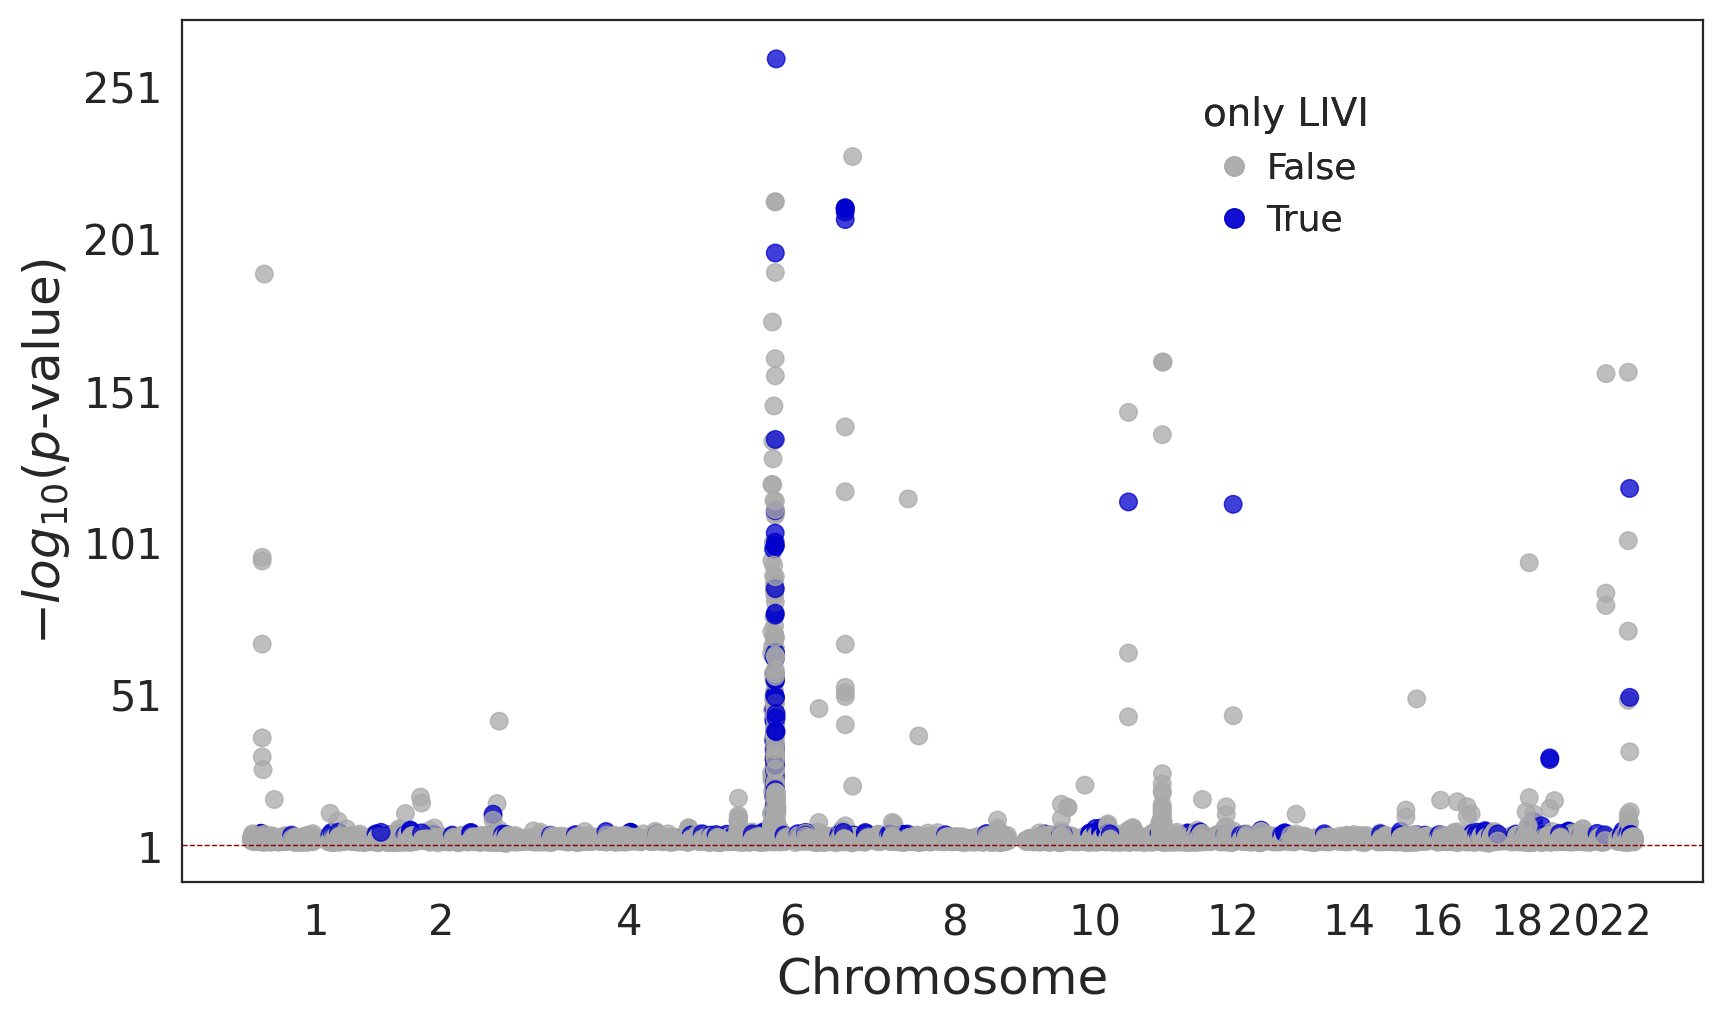

In [177]:
sns.set_style("white")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 5), constrained_layout=True)

sns.scatterplot(data=GxC_effects_all_min_pval, x="position2plot", y="m_log10_pvalue", hue="LIVI_only",
                alpha=0.75, s=40, palette=["darkgrey", "mediumblue"], edgecolor="face", ax=axs,
                rasterized=True, legend=True)

axs.set_xticks(tmp["mean_plot_position"])
axs.set_xticklabels(tmp["SNP_chrom"], fontsize=15, rotation=0)
axs.set_xlabel("Chromosome", fontsize=18)

y_ticks = np.arange(int(GxC_effects_all_min_pval.m_log10_pvalue.min()), int(GxC_effects_all_min_pval.m_log10_pvalue.max()), 50)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)
# significance threshold
axs.axhline(y=-np.log10(cut_off), color="darkred", linestyle="dashed", linewidth=0.5)

legend_hue_handles, legend_hue_labels = (axs.get_legend_handles_labels()[0],
                                         axs.get_legend_handles_labels()[1])

legend_hue = axs.legend(title="only LIVI", labels=legend_hue_labels, handles = legend_hue_handles, frameon=False, 
                        loc="upper left", handlelength=1, bbox_transform=axs.transAxes, ncol=1, markerscale=1.1,
                        title_fontsize=14, fontsize=13, bbox_to_anchor=[0.65,0.95])
axs.add_artist(legend_hue)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI.png"), 
            transparent=True, dpi=800, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_only-LIVI.eps"), 
            transparent=True, dpi=800, bbox_inches="tight")

In [80]:
GxC_effects_chr6 = GxC_effects_all.loc[GxC_effects_all.SNP_chrom == 6]
GxC_effects_chr6 = GxC_effects_chr6.filter(["Factor", "SNP_id", "SNP_chrom", "SNP_pos", "rsID", "m_log10_pvalue", "LIVI_only"]).drop_duplicates()
# smallest_pval_idx = GxC_effects_chr6.groupby("SNP_id", observed=True, group_keys=False).apply(lambda x: x.m_log10_pvalue.nlargest(1), include_groups=False).index
# GxC_effects_chr6 = GxC_effects_chr6.loc[smallest_pval_idx]
GxC_effects_chr6.head()

,Factor,SNP_id,SNP_chrom,SNP_pos,rsID,m_log10_pvalue,LIVI_only
2242800,U_Factor527,6:33546837,6,33546837,6:33546837,0.410117,False
2242801,U_Factor527,6:33659046,6,33659046,rs4711336,0.027553,False
2242802,U_Factor527,6:33618162,6,33618162,rs9394159,0.582585,False
2242803,U_Factor527,6:33552707,6,33552707,rs75080135,0.094677,True
2242804,U_Factor527,6:33548394,6,33548394,rs5745568,0.089935,True


In [81]:
GxC_effects_chr6.loc[GxC_effects_chr6.rsID.isin(snps2annotate_rs)]

,Factor,SNP_id,SNP_chrom,SNP_pos,rsID,m_log10_pvalue,LIVI_only
2244309,U_Factor528,6:29789171,6,29789171,rs1610677,0.189127,True
2245317,U_Factor590,6:29789171,6,29789171,rs1610677,0.602306,True
2246411,U_Factor527,6:29789171,6,29789171,rs1610677,0.228345,True
2248532,U_Factor464,6:29789171,6,29789171,rs1610677,0.003083,True
2248946,U_Factor679,6:29789171,6,29789171,rs1610677,0.358450,True
...,...,...,...,...,...,...,...
2961183,U_Factor267,6:29789171,6,29789171,rs1610677,0.040725,True
2962890,U_Factor66,6:29789171,6,29789171,rs1610677,0.266405,True
2963074,U_Factor140,6:29789171,6,29789171,rs1610677,0.313886,True
2963709,U_Factor699,6:29789171,6,29789171,rs1610677,0.418809,True


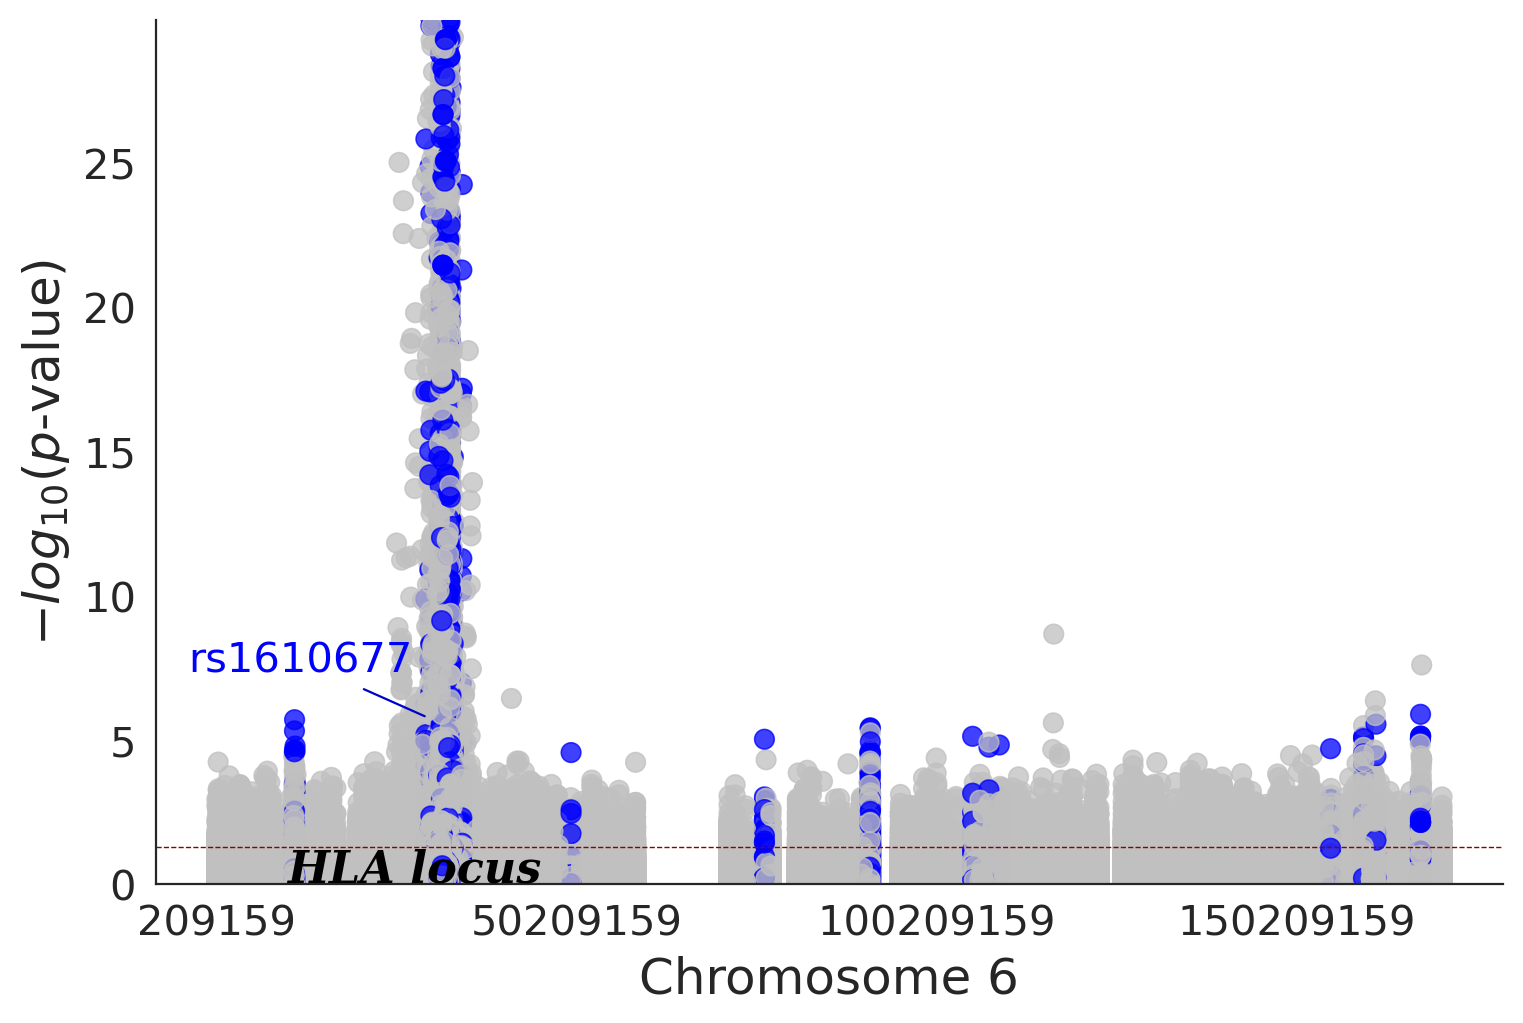

In [92]:
sns.set_style("white")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5), constrained_layout=True)

sns.scatterplot(data=GxC_effects_chr6, x="SNP_pos", y="m_log10_pvalue", hue="LIVI_only",
                alpha=0.75, s=50, palette=["silver", "blue"], edgecolor="face", ax=axs,
                rasterized=True, legend=False)

x_ticks = np.arange(GxC_effects_chr6.SNP_pos.min(), GxC_effects_chr6.SNP_pos.max(), 5e7, dtype=int)
axs.set_xticks(x_ticks)
axs.set_xticklabels(x_ticks, fontsize=15)
axs.set_xlabel("Chromosome 6", fontsize=18)

axs.set_ylim(0,30)
y_ticks = np.arange(0, 30, 5)
axs.set_yticks(y_ticks)
axs.set_yticklabels(y_ticks, fontsize=15)
axs.set_ylabel("$-log_{10}$($p$-value)", fontsize=18)
# significance threshold
axs.axhline(y=-np.log10(cut_off), color="darkred", linestyle="dashed", linewidth=0.5)

axs.text(x = HLA_summary.loc[HLA_summary.gene_name == "HLA-A"].gene_start.iloc[0]-2e7, y=0.5, s="HLA locus", va="center", 
         fontdict={"fontsize":16, "color":"black", "style":"italic", "weight":"bold", "family":"serif"})

offset = 0 
# annotate selected SNPs
for _, row in GxC_effects_chr6.iterrows():
    if row["rsID"] in snps2annotate_rs and row["Factor"] in factors4snps and row["m_log10_pvalue"] > -np.log10(cut_off):
        if row["rsID"] == "rs1610677":
            axs.annotate(text=row["rsID"],
                     xy=(row["SNP_pos"], row["m_log10_pvalue"]),
                     xytext=(row["SNP_pos"]-18e6, row["m_log10_pvalue"]+2),
                     arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
                     ha="center",
                     va="center",
                     weight="regular",
                     alpha=1,
                     fontsize=15,
                     color="blue")
        # elif row["rsID"] == "rs2517532":
        #     axs.annotate(text=row["rsID"],
        #              xy=(row["SNP_pos"], row["m_log10_pvalue"]),
        #              xytext=(row["SNP_pos"]+1e6, row["m_log10_pvalue"]+2),
        #              arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
        #              ha="center",
        #              va="center",
        #              weight="regular",
        #              alpha=1,
        #              fontsize=15,
        #              color="blue")
        elif row["SNP_chrom"] == 11:
            axs.annotate(text=row["rsID"],
                     xy=(row["SNP_pos"], row["m_log10_pvalue"]),
                     xytext=(row["SNP_pos"]-1e8, row["m_log10_pvalue"]+4),
                     arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
                     ha="center",
                     va="center",
                     weight="regular",
                     alpha=1,
                     fontsize=15,
                     color="blue")
        else:
            axs.annotate(text=row["rsID"],
                         xy=(row["SNP_pos"], row["m_log10_pvalue"]),
                         xytext=(row["SNP_pos"], row["m_log10_pvalue"]+2),
                         arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="mediumblue", linewidth=0.8),
                         ha="center",
                         va="center",
                         weight="regular",
                         alpha=1,
                         fontsize=15,
                         color="blue")


axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_chromosome-6-one-SNP_only-LIVI_wo-spines.png"), 
            transparent=False, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_chromosome-6-one-SNP_only-LIVI_wo-spines.eps"), 
            transparent=False, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_GxC-effects_Manhattan-plot_chromosome-6-one-SNP_only-LIVI_wo-spines.pdf"), 
            transparent=False, dpi=600, bbox_inches="tight")

In [142]:
HLA_summary.loc[HLA_summary.gene_name == "HLA-A"].gene_start.iloc[0]

29909037

In [148]:
HLA_summary.gene_end.max()

33054978